# Temporal Class Profiling

In [1]:
from os import listdir
from os.path import abspath, join
import glob

import xml.etree.ElementTree as et
from datetime import datetime, date

import numpy as np
import pandas as pd
import geopandas as gpd

import rasterio, rasterio.mask
from shapely.geometry import mapping
import scipy.ndimage as ndimage

import pyarrow as pa
import pyarrow.parquet as pq

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import dates

path = {'root': abspath("/media/tharen/eSSD")}

path['iota2'] = join(path['root'], "iota2")
path['sensor'] = join(path['iota2'], "sensor_data")
path['vector'] = join(path['iota2'], "vector_data")

path['shp'] = join(path['root'], "shapefiles")
path['reshp'] = join(path['shp'], "reshaped")

path['prof'] = join(path['root'], "profile")
path['diag'] = join(path['prof'], "diagrams")

## Load Shapefile

In [2]:
glob.glob(join(path['vector'], "*.shp"))

['/media/tharen/eSSD/iota2/vector_data/min_split.shp']

In [3]:
shapefile = [shp for shp in glob.glob(join(path['vector'], "*.shp"))][0]
shapeframe = gpd.read_file(shapefile)
shapeframe

ess                                           geometry
0      1111100  POLYGON ((509381.635 5290626.830, 509384.096 5...
1      1111100  POLYGON ((401852.559 5290877.679, 401851.983 5...
2      1111100  POLYGON ((406295.798 5290220.000, 406289.399 5...
3      1111100  POLYGON ((406715.144 5290237.995, 406725.700 5...
4      1111100  POLYGON ((415450.138 5290535.709, 415452.712 5...
...        ...                                                ...
16605  2000000  POLYGON ((434811.809 5312512.404, 435350.990 5...
16606  2000000  POLYGON ((434667.781 5312726.687, 434631.239 5...
16607  2000000  POLYGON ((434631.239 5312781.052, 434667.781 5...
16608  4000000  POLYGON ((432958.501 5319038.987, 432962.221 5...
16609  4000000  POLYGON ((432976.326 5318788.144, 432968.008 5...

[16610 rows x 2 columns]

## Identify All Stacks to Profile

In [4]:
products = glob.glob(join(path['sensor'], '**', '*_STACK.tif'), recursive=True)
products

['/media/tharen/eSSD/iota2/sensor_data/sentinel_2_l3a/T31UDP/SENTINEL2X_20180115-000000-000_L3A_T31UDP_C_V2-0/SENTINEL2X_20180115-000000-000_L3A_T31UDP_C_V2-0_FRC_STACK.tif',
 '/media/tharen/eSSD/iota2/sensor_data/sentinel_2_l3a/T31UDP/SENTINEL2X_20180215-000000-000_L3A_T31UDP_C_V2-0/SENTINEL2X_20180215-000000-000_L3A_T31UDP_C_V2-0_FRC_STACK.tif',
 '/media/tharen/eSSD/iota2/sensor_data/sentinel_2_l3a/T31UDP/SENTINEL2X_20180315-000000-000_L3A_T31UDP_C_V2-0/SENTINEL2X_20180315-000000-000_L3A_T31UDP_C_V2-0_FRC_STACK.tif',
 '/media/tharen/eSSD/iota2/sensor_data/sentinel_2_l3a/T31UDP/SENTINEL2X_20180415-000000-000_L3A_T31UDP_C_V2-0/SENTINEL2X_20180415-000000-000_L3A_T31UDP_C_V2-0_FRC_STACK.tif',
 '/media/tharen/eSSD/iota2/sensor_data/sentinel_2_l3a/T31UDP/SENTINEL2X_20180503-225640-865_L3A_T31UDP_D_V1-0/SENTINEL2X_20180503-225640-865_L3A_T31UDP_D_V1-0_FRC_STACK.tif',
 '/media/tharen/eSSD/iota2/sensor_data/sentinel_2_l3a/T31UDP/SENTINEL2X_20180515-000000-000_L3A_T31UDP_C_V2-0/SENTINEL2X_2018

In [5]:
products_meta_xml = glob.glob(join(path['sensor'], '**', '*_MTD_ALL.xml'), recursive=True)
products_meta = [et.parse(p).getroot() for p in products_meta_xml]

len(products_meta_xml), products_meta_xml

(14,
 ['/media/tharen/eSSD/iota2/sensor_data/sentinel_2_l3a/T31UDP/SENTINEL2X_20180115-000000-000_L3A_T31UDP_C_V2-0/SENTINEL2X_20180115-000000-000_L3A_T31UDP_C_V2-0_MTD_ALL.xml',
  '/media/tharen/eSSD/iota2/sensor_data/sentinel_2_l3a/T31UDP/SENTINEL2X_20180215-000000-000_L3A_T31UDP_C_V2-0/SENTINEL2X_20180215-000000-000_L3A_T31UDP_C_V2-0_MTD_ALL.xml',
  '/media/tharen/eSSD/iota2/sensor_data/sentinel_2_l3a/T31UDP/SENTINEL2X_20180315-000000-000_L3A_T31UDP_C_V2-0/SENTINEL2X_20180315-000000-000_L3A_T31UDP_C_V2-0_MTD_ALL.xml',
  '/media/tharen/eSSD/iota2/sensor_data/sentinel_2_l3a/T31UDP/SENTINEL2X_20180415-000000-000_L3A_T31UDP_C_V2-0/SENTINEL2X_20180415-000000-000_L3A_T31UDP_C_V2-0_MTD_ALL.xml',
  '/media/tharen/eSSD/iota2/sensor_data/sentinel_2_l3a/T31UDP/SENTINEL2X_20180503-225640-865_L3A_T31UDP_D_V1-0/SENTINEL2X_20180503-225640-865_L3A_T31UDP_D_V1-0_MTD_ALL.xml',
  '/media/tharen/eSSD/iota2/sensor_data/sentinel_2_l3a/T31UDP/SENTINEL2X_20180515-000000-000_L3A_T31UDP_C_V2-0/SENTINEL2X_201

In [6]:
def get_date(meta):
    date_str = meta.find('.//ACQUISITION_DATE').text
    return datetime.strptime(date_str, '%Y-%m-%dT%H:%M:%S.%fZ').date()
    
def get_images(meta):
    images = meta.findall('.//Image_File_List/*')
    return {i.attrib['band_id']: i.text for i in images} 

meta = {get_date(m): get_images(m) for m in products_meta}
meta

{datetime.date(2018, 1, 15): {'B11': 'SENTINEL2X_20180115-000000-000_L3A_T31UDP_C_V2-0_FRC_B11.tif',
  'B12': 'SENTINEL2X_20180115-000000-000_L3A_T31UDP_C_V2-0_FRC_B12.tif',
  'B2': 'SENTINEL2X_20180115-000000-000_L3A_T31UDP_C_V2-0_FRC_B2.tif',
  'B3': 'SENTINEL2X_20180115-000000-000_L3A_T31UDP_C_V2-0_FRC_B3.tif',
  'B4': 'SENTINEL2X_20180115-000000-000_L3A_T31UDP_C_V2-0_FRC_B4.tif',
  'B5': 'SENTINEL2X_20180115-000000-000_L3A_T31UDP_C_V2-0_FRC_B5.tif',
  'B6': 'SENTINEL2X_20180115-000000-000_L3A_T31UDP_C_V2-0_FRC_B6.tif',
  'B7': 'SENTINEL2X_20180115-000000-000_L3A_T31UDP_C_V2-0_FRC_B7.tif',
  'B8': 'SENTINEL2X_20180115-000000-000_L3A_T31UDP_C_V2-0_FRC_B8.tif',
  'B8A': 'SENTINEL2X_20180115-000000-000_L3A_T31UDP_C_V2-0_FRC_B8A.tif'},
 datetime.date(2018, 2, 15): {'B11': 'SENTINEL2X_20180215-000000-000_L3A_T31UDP_C_V2-0_FRC_B11.tif',
  'B12': 'SENTINEL2X_20180215-000000-000_L3A_T31UDP_C_V2-0_FRC_B12.tif',
  'B2': 'SENTINEL2X_20180215-000000-000_L3A_T31UDP_C_V2-0_FRC_B2.tif',
  'B3': 'S

In [7]:
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']

## Demonstrate Erosion

In [ ]:
merged = list(filter(lambda p: 'merged' in p, glob.glob(join(path['shp'], "*.shp"))))[0]
mergedframe = gpd.read_file(merged)

# Same shape, first eroded, second not
demoshapes = [(0, shapeframe.loc[0]), (17316, mergedframe.loc[17316])]

stack = products[7] # Identified to not be cloud covered

In [ ]:
# Process mask before feature extraction
def process_mask(out_image, out_transform):

    # Erode Masked Image by 1
    for b, band in enumerate(out_image):
        erosion = ndimage.binary_erosion(band)
        out_image[b][erosion == False] = 0

    # Crop Image by 1
    out_image = out_image[:, 1:-1, 1:-1]

    # Transform window to place crop correctly
    win = rasterio.windows.Window.from_slices(slice(1, -1),
                                              slice(1, -1),
                                              height=100,
                                              width=100)
    out_transform = rasterio.windows.transform(win, out_transform)

    return out_image, out_transform

with rasterio.open(stack) as stk:
    for i, (num, row) in enumerate(demoshapes):
        out_image, out_transform = rasterio.mask.mask(
            stk, [mapping(row['geometry'])], crop=True,
            all_touched=True)  #, nodata=-1)

        # Setup file path for export
        file_path = join(path['diag'], f'demo_{i}_{num}.tif')

        # Export Masked Image
        with rasterio.open(file_path, "w", **out_meta) as dest:
            dest.write(out_image)
            
        out_image, out_transform = process_mask(out_image, out_transform)
        
        file_path = join(path['diag'], f'demo_{i}_{num}_crop.tif')

        # Update Meta for export
        out_meta = stk.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

## Extract Pixels

In [8]:
def process_mask_pixels(out_image, nodata):
    # Erode Masked Image by 1
    for b, band in enumerate(out_image):
        erosion = ndimage.binary_erosion(band)
        out_image[b][erosion == False] = 0

    # Crop Image by 1
    out_image = out_image[:, 1:-1, 1:-1]

    # Extract Pixels
    return np.array([band[band != nodata] for band in out_image])


def compute_statistics(pixels):
    return pd.Series(pixels).describe().T.to_dict()


def class_temporal_profile(shapeframe, products, bands, nodata=-10000):
    stats = []

    for band, date in ((band, date) for date in products.keys()
                       for band in bands):
        
        print(f'Band {band} on {date}:')
        
        image = next(
            glob.iglob(join(path['sensor'], '**', products[date][band]),
                       recursive=True))

        with rasterio.open(image) as img:
            for ess in shapeframe.ess.unique():
                
                print(ess, end='\t')
                stat = {'ess': ess, 'band': band, 'date': date}
                pixels = []

                for _, geom in shapeframe[shapeframe.ess ==
                                          ess].geometry.items():
                    # Extract Mask
                    out_image, _ = rasterio.mask.mask(img, [mapping(geom)],
                                                      crop=True,
                                                      all_touched=True,
                                                      nodata=nodata)

                    # Remove Out of Mask Pixels and add mask pixels to class pixels
                    pixels.append(process_mask_pixels(out_image, nodata))

                # Flatten Pixels
                pixels = np.concatenate(pixels, axis=None)

                # Compute Statistics
                stat.update(compute_statistics(pixels))

                # Attach labels
                stats.append(stat)
                
            print('\n')

    return pd.DataFrame(stats)

In [9]:
statistics = class_temporal_profile(shapeframe, meta, bands)
statistics.date = pd.to_datetime(statistics.date)
statistics.to_parquet(join(path['prof'], 'statistics.parq'), index=False)

Band B2 on 2018-01-15:
1111100	1113100	1114111	1115000	1116000	1117000	1125000	1130000	1211000	1213000	1216000	1225000	1230000	1381100	1390000	2000000	4000000	5000000	

Band B3 on 2018-01-15:
1111100	1113100	1114111	1115000	1116000	1117000	1125000	1130000	1211000	1213000	1216000	1225000	1230000	1381100	1390000	2000000	4000000	5000000	

Band B4 on 2018-01-15:
1111100	1113100	1114111	1115000	1116000	1117000	1125000	1130000	1211000	1213000	1216000	1225000	1230000	1381100	1390000	2000000	4000000	5000000	

Band B5 on 2018-01-15:
1111100	1113100	1114111	1115000	1116000	1117000	1125000	1130000	1211000	1213000	1216000	1225000	1230000	1381100	1390000	2000000	4000000	5000000	

Band B6 on 2018-01-15:
1111100	1113100	1114111	1115000	1116000	1117000	1125000	1130000	1211000	1213000	1216000	1225000	1230000	1381100	1390000	2000000	4000000	5000000	

Band B7 on 2018-01-15:
1111100	1113100	1114111	1115000	1116000	1117000	1125000	1130000	1211000	1213000	1216000	1225000	1230000	1381100	1390000	2000000	4000

1111100	1113100	1114111	1115000	1116000	1117000	1125000	1130000	1211000	1213000	1216000	1225000	1230000	1381100	1390000	2000000	4000000	5000000	

Band B12 on 2018-05-03:
1111100	1113100	1114111	1115000	1116000	1117000	1125000	1130000	1211000	1213000	1216000	1225000	1230000	1381100	1390000	2000000	4000000	5000000	

Band B2 on 2018-05-15:
1111100	1113100	1114111	1115000	1116000	1117000	1125000	1130000	1211000	1213000	1216000	1225000	1230000	1381100	1390000	2000000	4000000	5000000	

Band B3 on 2018-05-15:
1111100	1113100	1114111	1115000	1116000	1117000	1125000	1130000	1211000	1213000	1216000	1225000	1230000	1381100	1390000	2000000	4000000	5000000	

Band B4 on 2018-05-15:
1111100	1113100	1114111	1115000	1116000	1117000	1125000	1130000	1211000	1213000	1216000	1225000	1230000	1381100	1390000	2000000	4000000	5000000	

Band B5 on 2018-05-15:
1111100	1113100	1114111	1115000	1116000	1117000	1125000	1130000	1211000	1213000	1216000	1225000	1230000	1381100	1390000	2000000	4000000	5000000	

Band B6 

1111100	1113100	1114111	1115000	1116000	1117000	1125000	1130000	1211000	1213000	1216000	1225000	1230000	1381100	1390000	2000000	4000000	5000000	

Band B8A on 2018-08-15:
1111100	1113100	1114111	1115000	1116000	1117000	1125000	1130000	1211000	1213000	1216000	1225000	1230000	1381100	1390000	2000000	4000000	5000000	

Band B11 on 2018-08-15:
1111100	1113100	1114111	1115000	1116000	1117000	1125000	1130000	1211000	1213000	1216000	1225000	1230000	1381100	1390000	2000000	4000000	5000000	

Band B12 on 2018-08-15:
1111100	1113100	1114111	1115000	1116000	1117000	1125000	1130000	1211000	1213000	1216000	1225000	1230000	1381100	1390000	2000000	4000000	5000000	

Band B2 on 2018-09-15:
1111100	1113100	1114111	1115000	1116000	1117000	1125000	1130000	1211000	1213000	1216000	1225000	1230000	1381100	1390000	2000000	4000000	5000000	

Band B3 on 2018-09-15:
1111100	1113100	1114111	1115000	1116000	1117000	1125000	1130000	1211000	1213000	1216000	1225000	1230000	1381100	1390000	2000000	4000000	5000000	

Band B

In [10]:
statistics = pq.ParquetDataset(join(path['prof'], 'statistics.parq')).read().to_pandas()
statistics

ess band       date      count         mean          std    min  \
0     1111100   B2 2018-01-15  2320837.0  1569.146040  1980.867538    0.0   
1     1113100   B2 2018-01-15     1437.0   316.669450   267.705415    0.0   
2     1114111   B2 2018-01-15   100446.0  1399.091601  1856.051254    0.0   
3     1115000   B2 2018-01-15    17900.0  2620.328156  2038.268912    0.0   
4     1116000   B2 2018-01-15   132157.0  2148.142058  2368.774947    0.0   
...       ...  ...        ...        ...          ...          ...    ...   
2515  1381100  B12 2018-12-15   208851.0   851.084553  1098.671782   27.0   
2516  1390000  B12 2018-12-15     1846.0   618.622969   424.213643  116.0   
2517  2000000  B12 2018-12-15    54685.0   881.480534  1088.573945   36.0   
2518  4000000  B12 2018-12-15    24084.0   892.466243   795.348801   27.0   
2519  5000000  B12 2018-12-15     1464.0  1243.243169  1285.226262  204.0   

         25%     50%     75%      max  
0      237.0   637.0  2278.0  13749.0  
1      103.0   280.0   468.0   1161.0  
2      165.0   337.0  2245.0   9935.0  
3     1094.0  1800.0  3825.0   9398.0  
4      430.0  1191.0  3018.0  12086.0  
...      ...     ...     ...      ...  
2515   381.0   500.0   660.0   9924.0  
2516   403.5   562.0   732.0   4957.0  
2517   363.0   570.0   811.0  10425.0  
2518   555.0   743.5   939.0   8192.0  
2519   800.0   935.0  1109.0   8948.0  

[2520 rows x 11 columns]

## Plot Statistics

In [11]:
def box_stat(stat):
    return {
        'label': stat['date'].date(),
        'whislo': stat['min'],  # Bottom whisker position
        'q1': stat['25%'],  # First quartile (25th percentile)
        'mean': stat['mean'],  # Mean
        'med': stat['50%'],  # Median         (50th percentile)
        'q3': stat['75%'],  # Third quartile (75th percentile)
        'whishi': stat['max'],  # Top whisker position
    }

### Class Temporal Profile

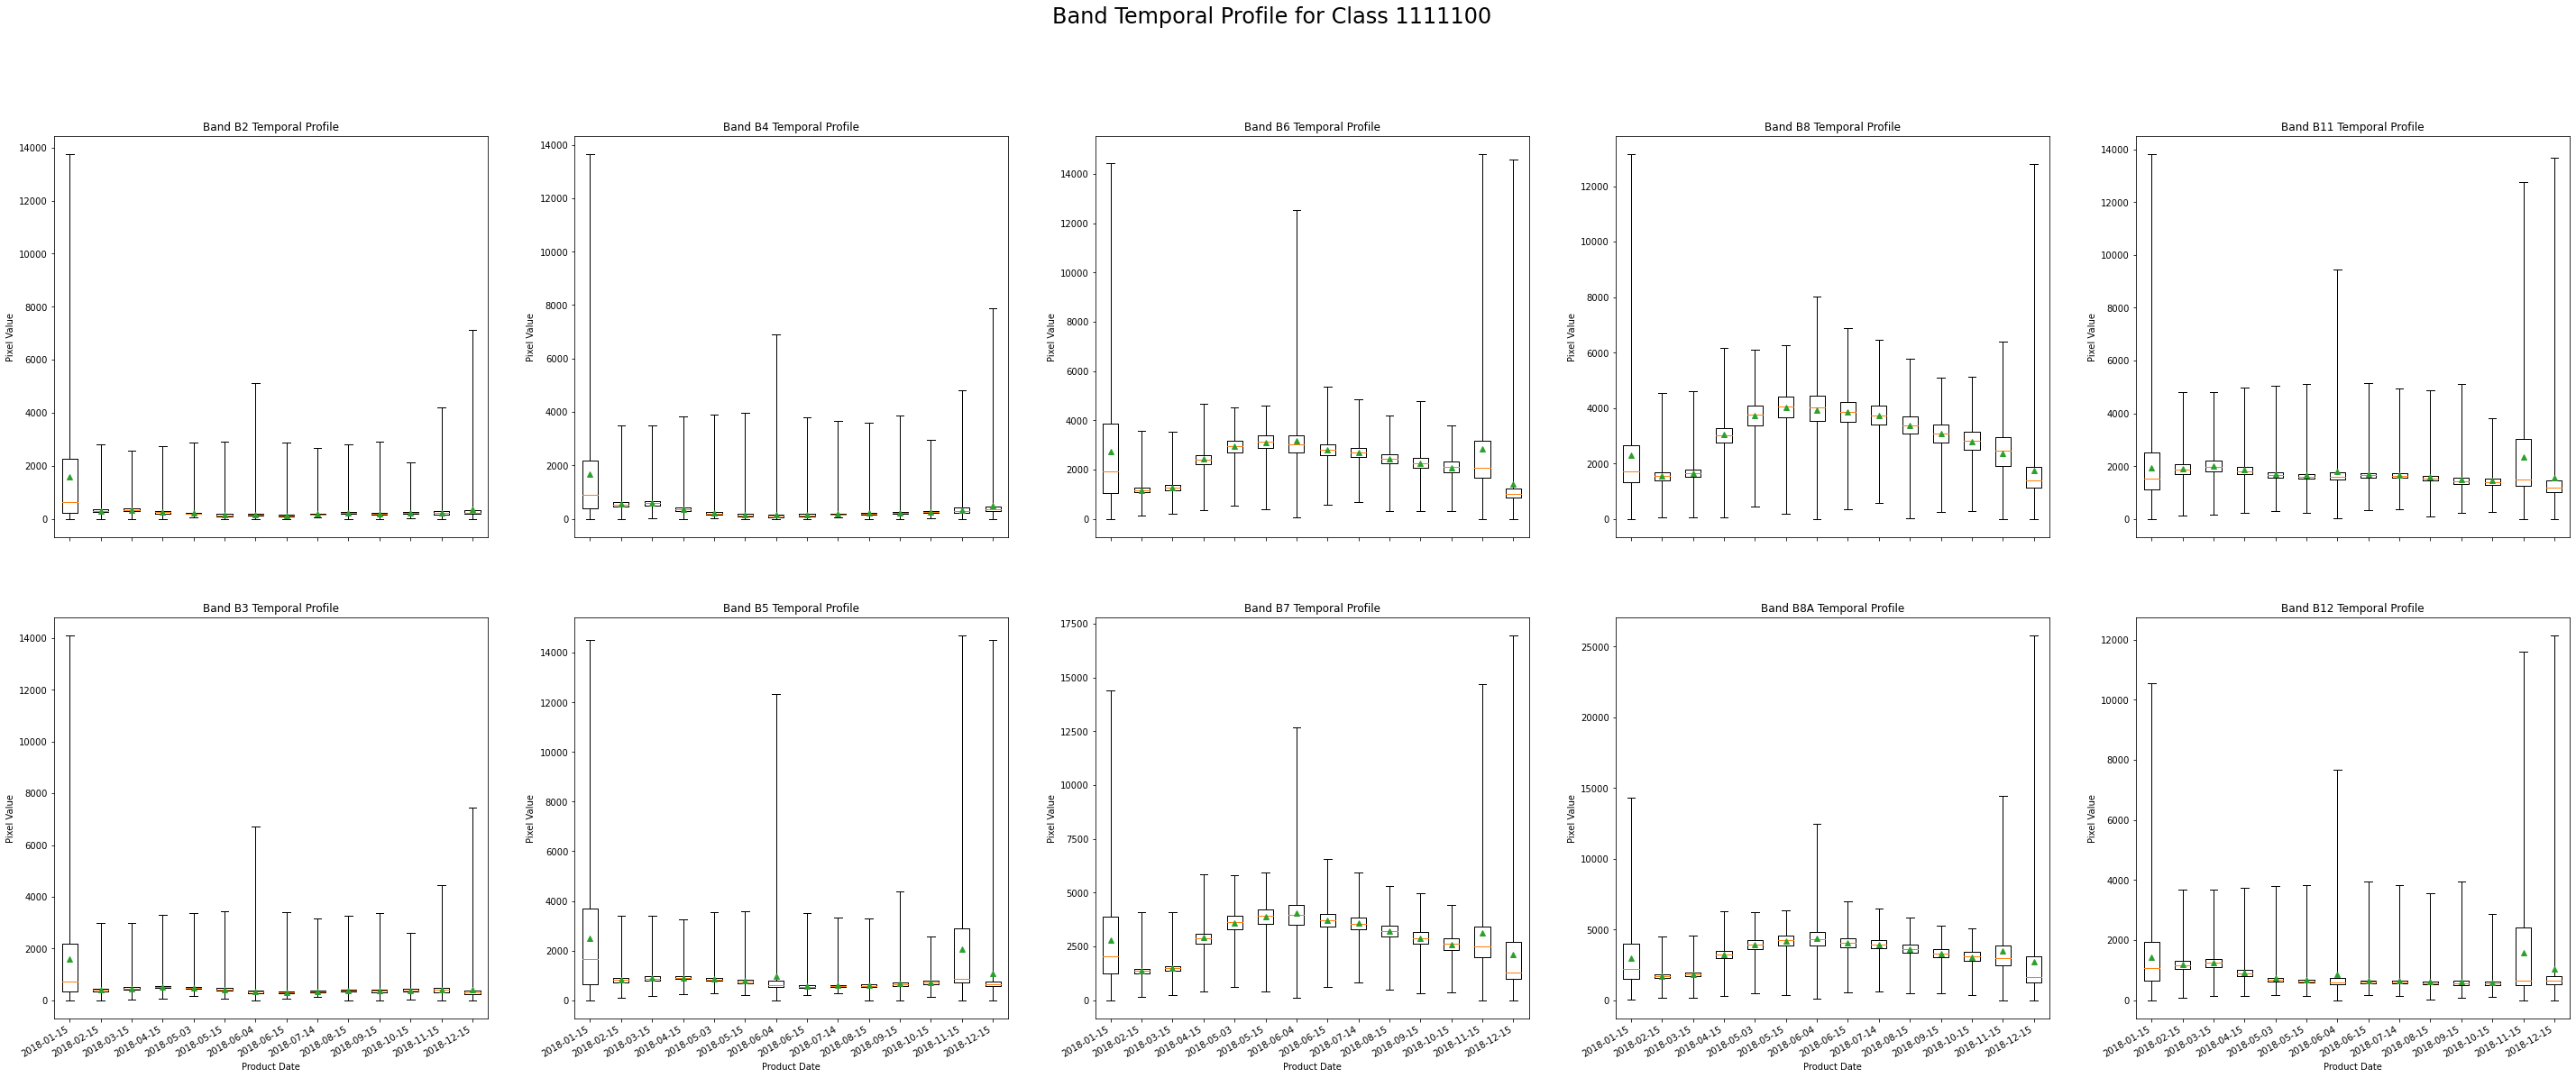

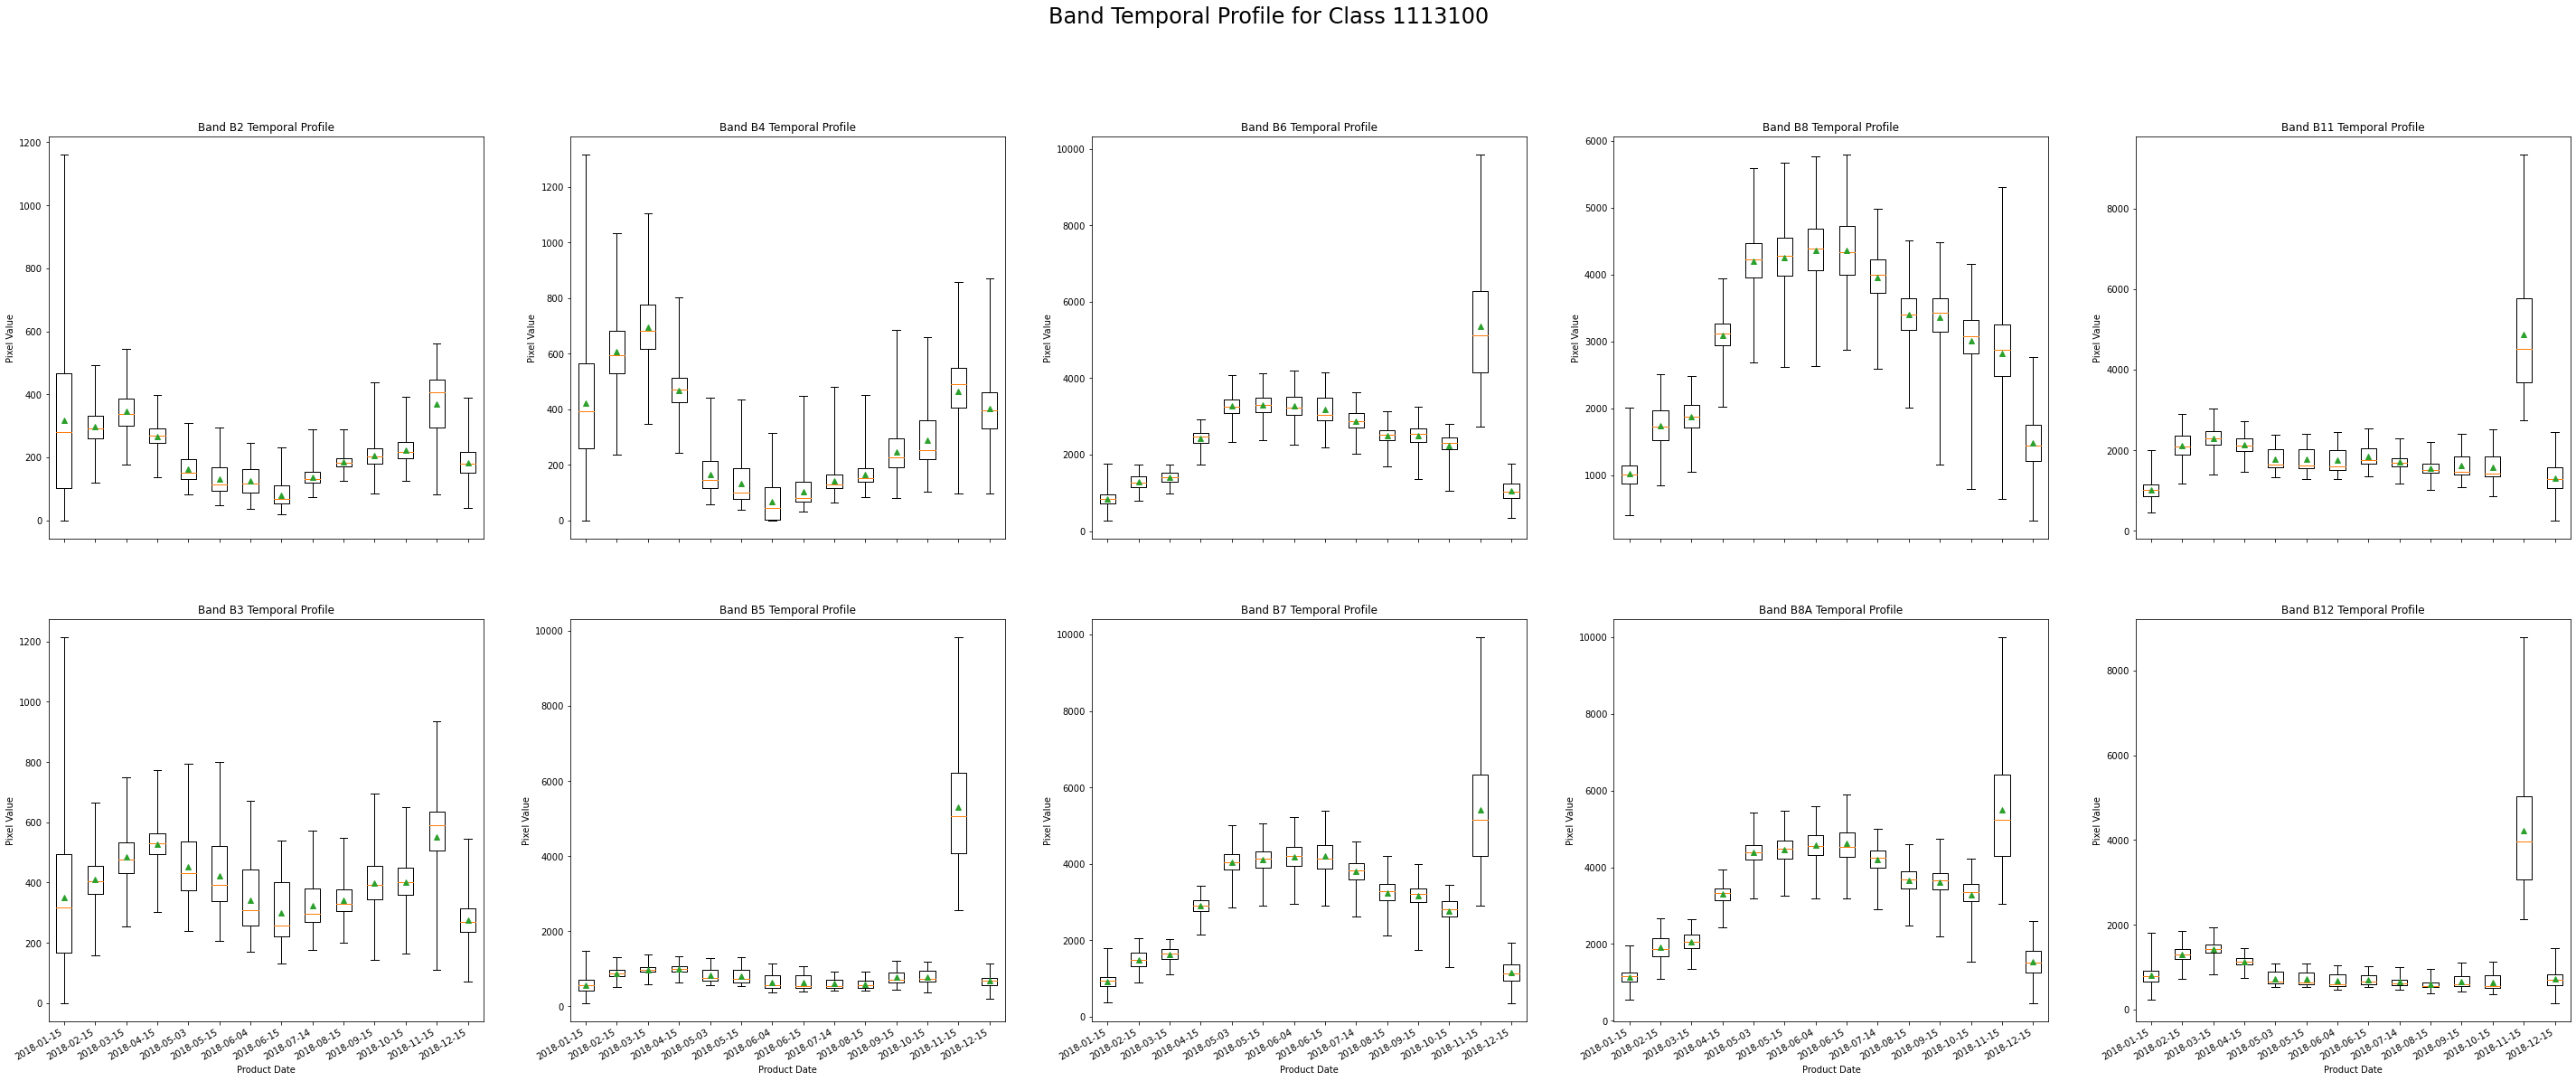

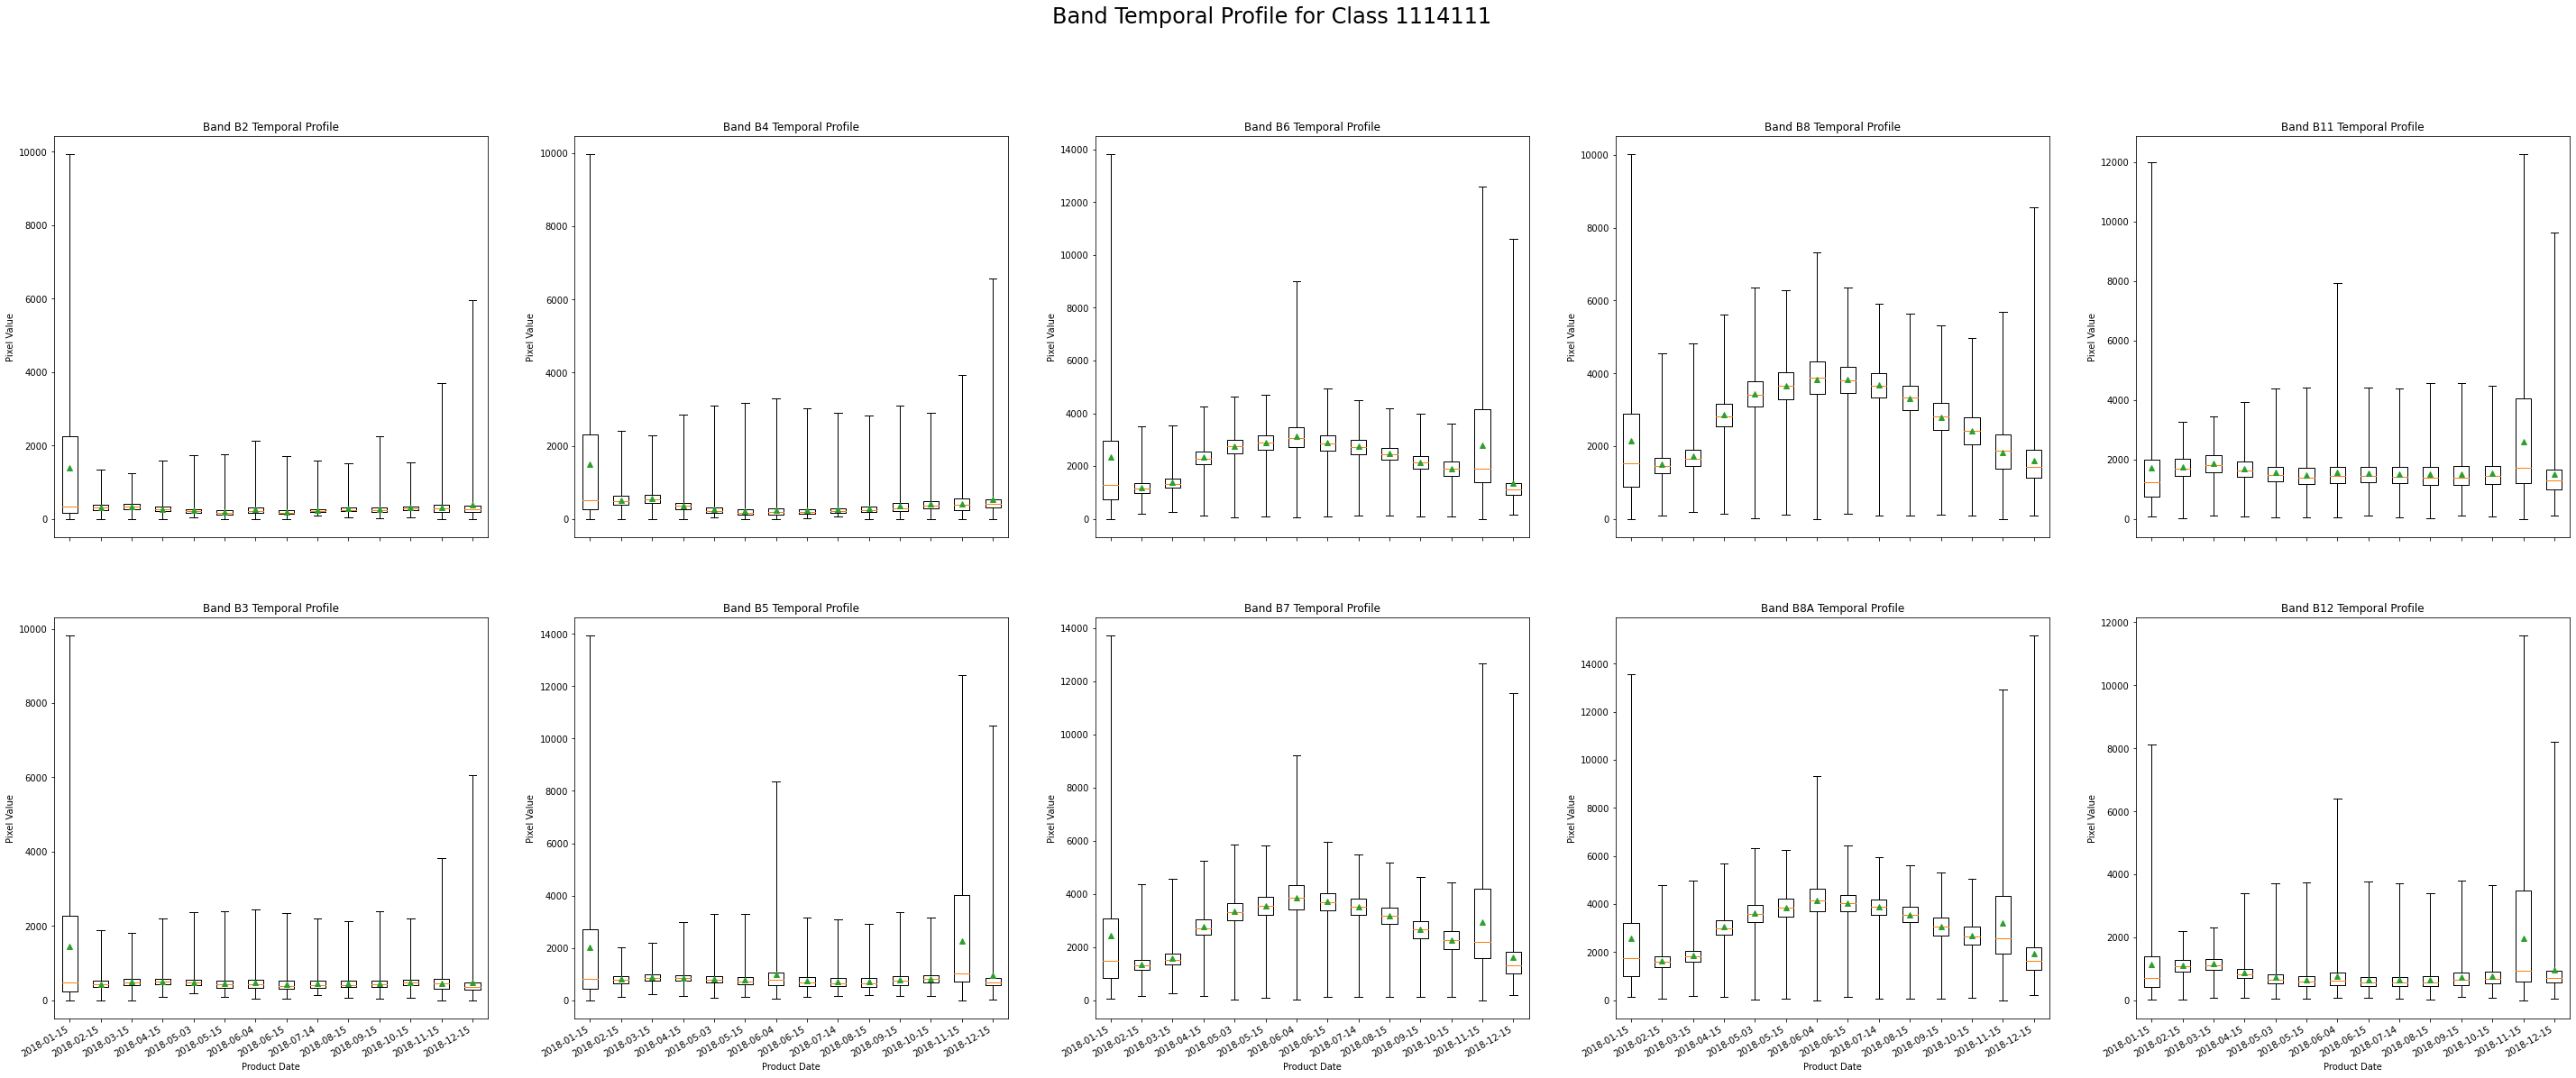

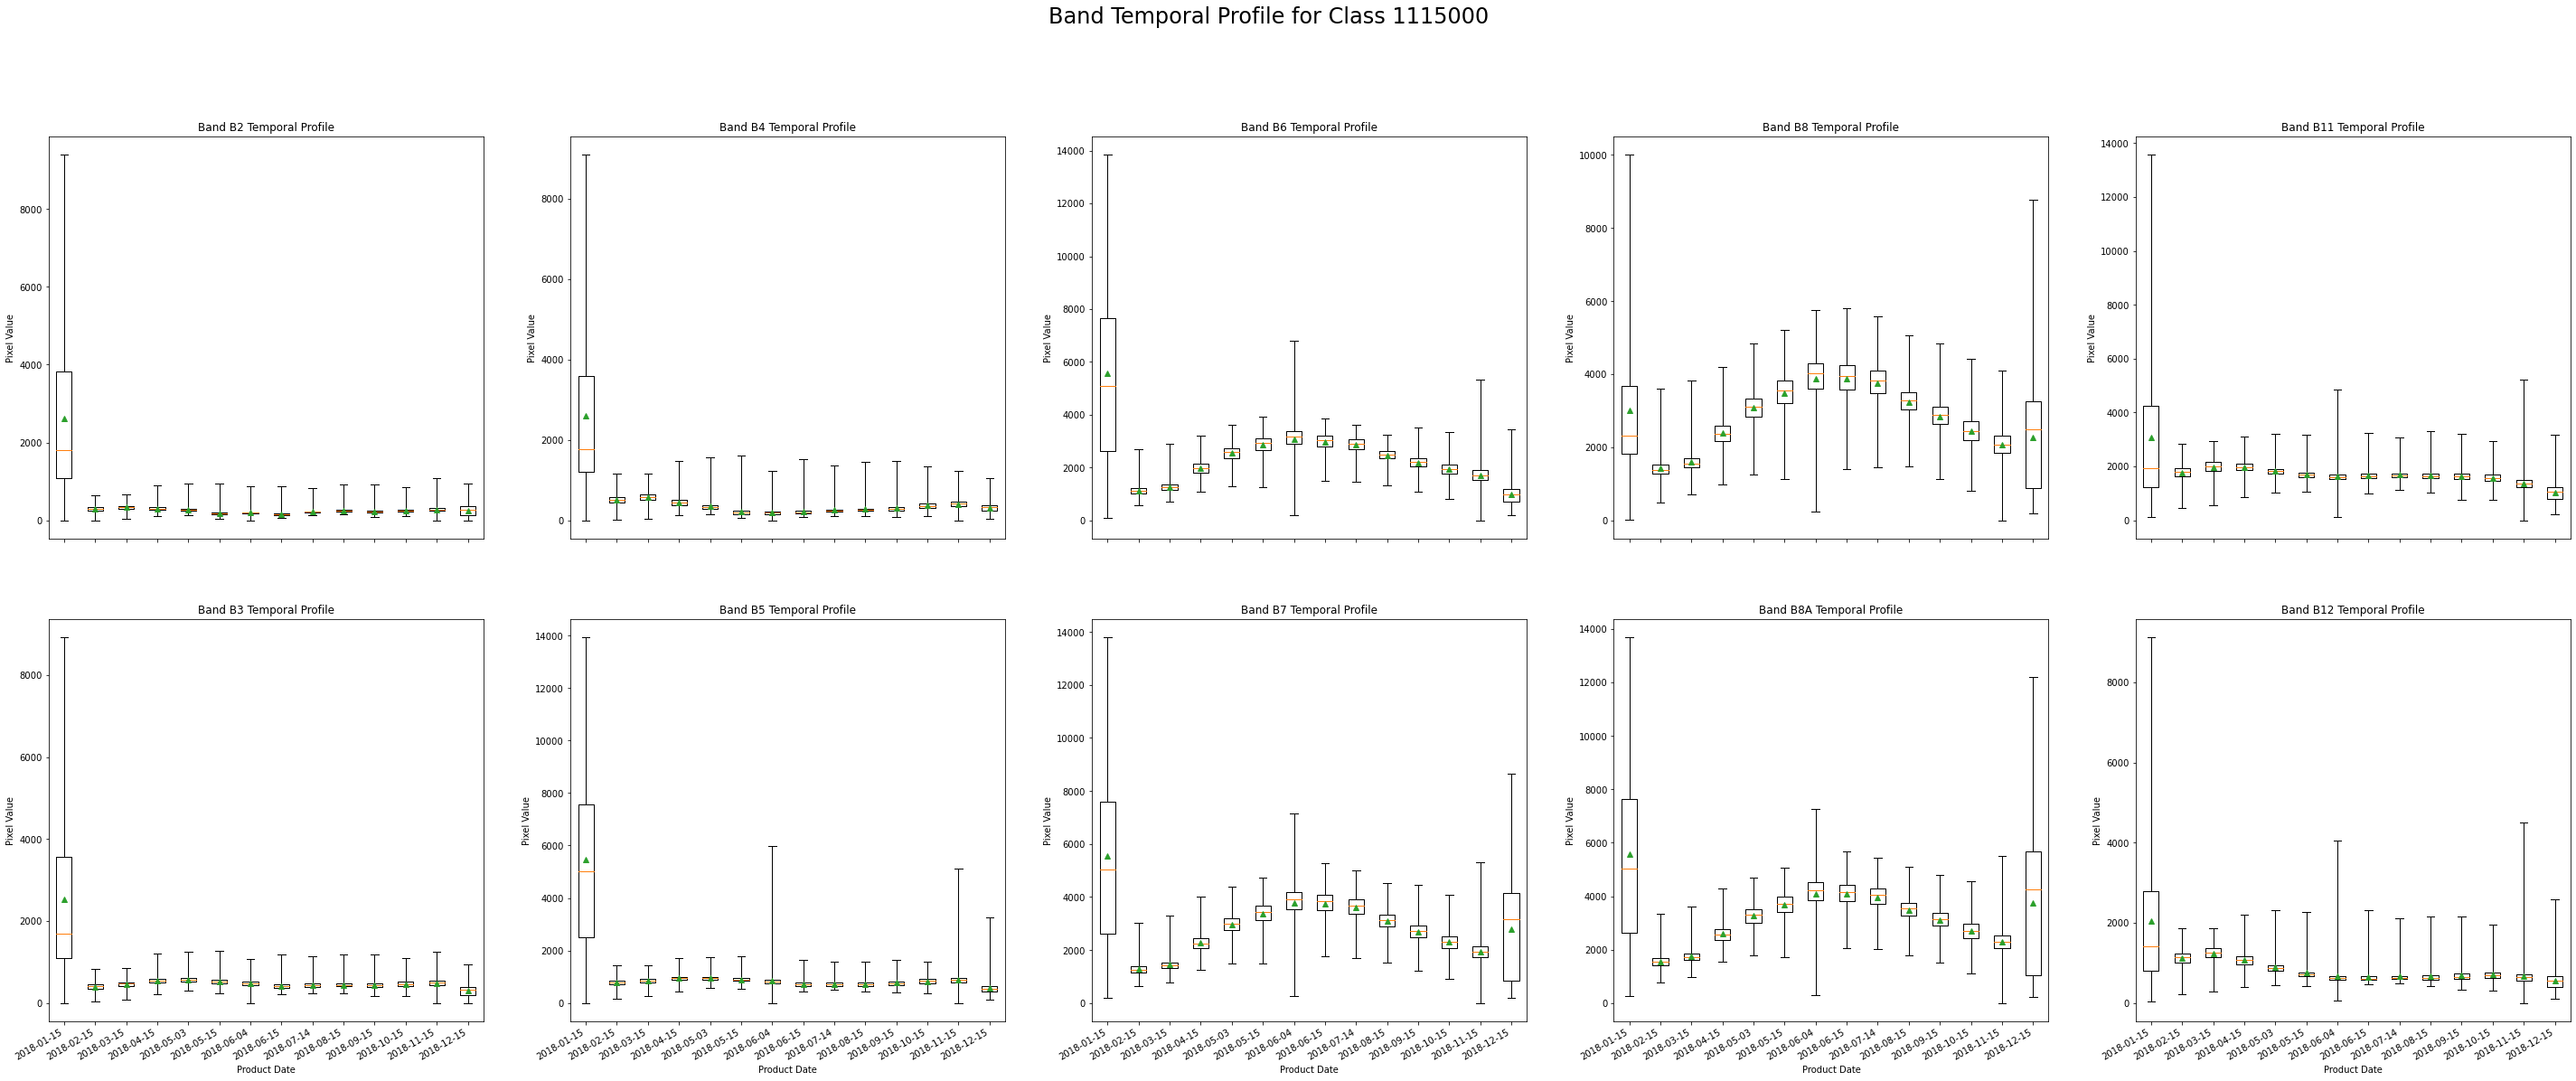

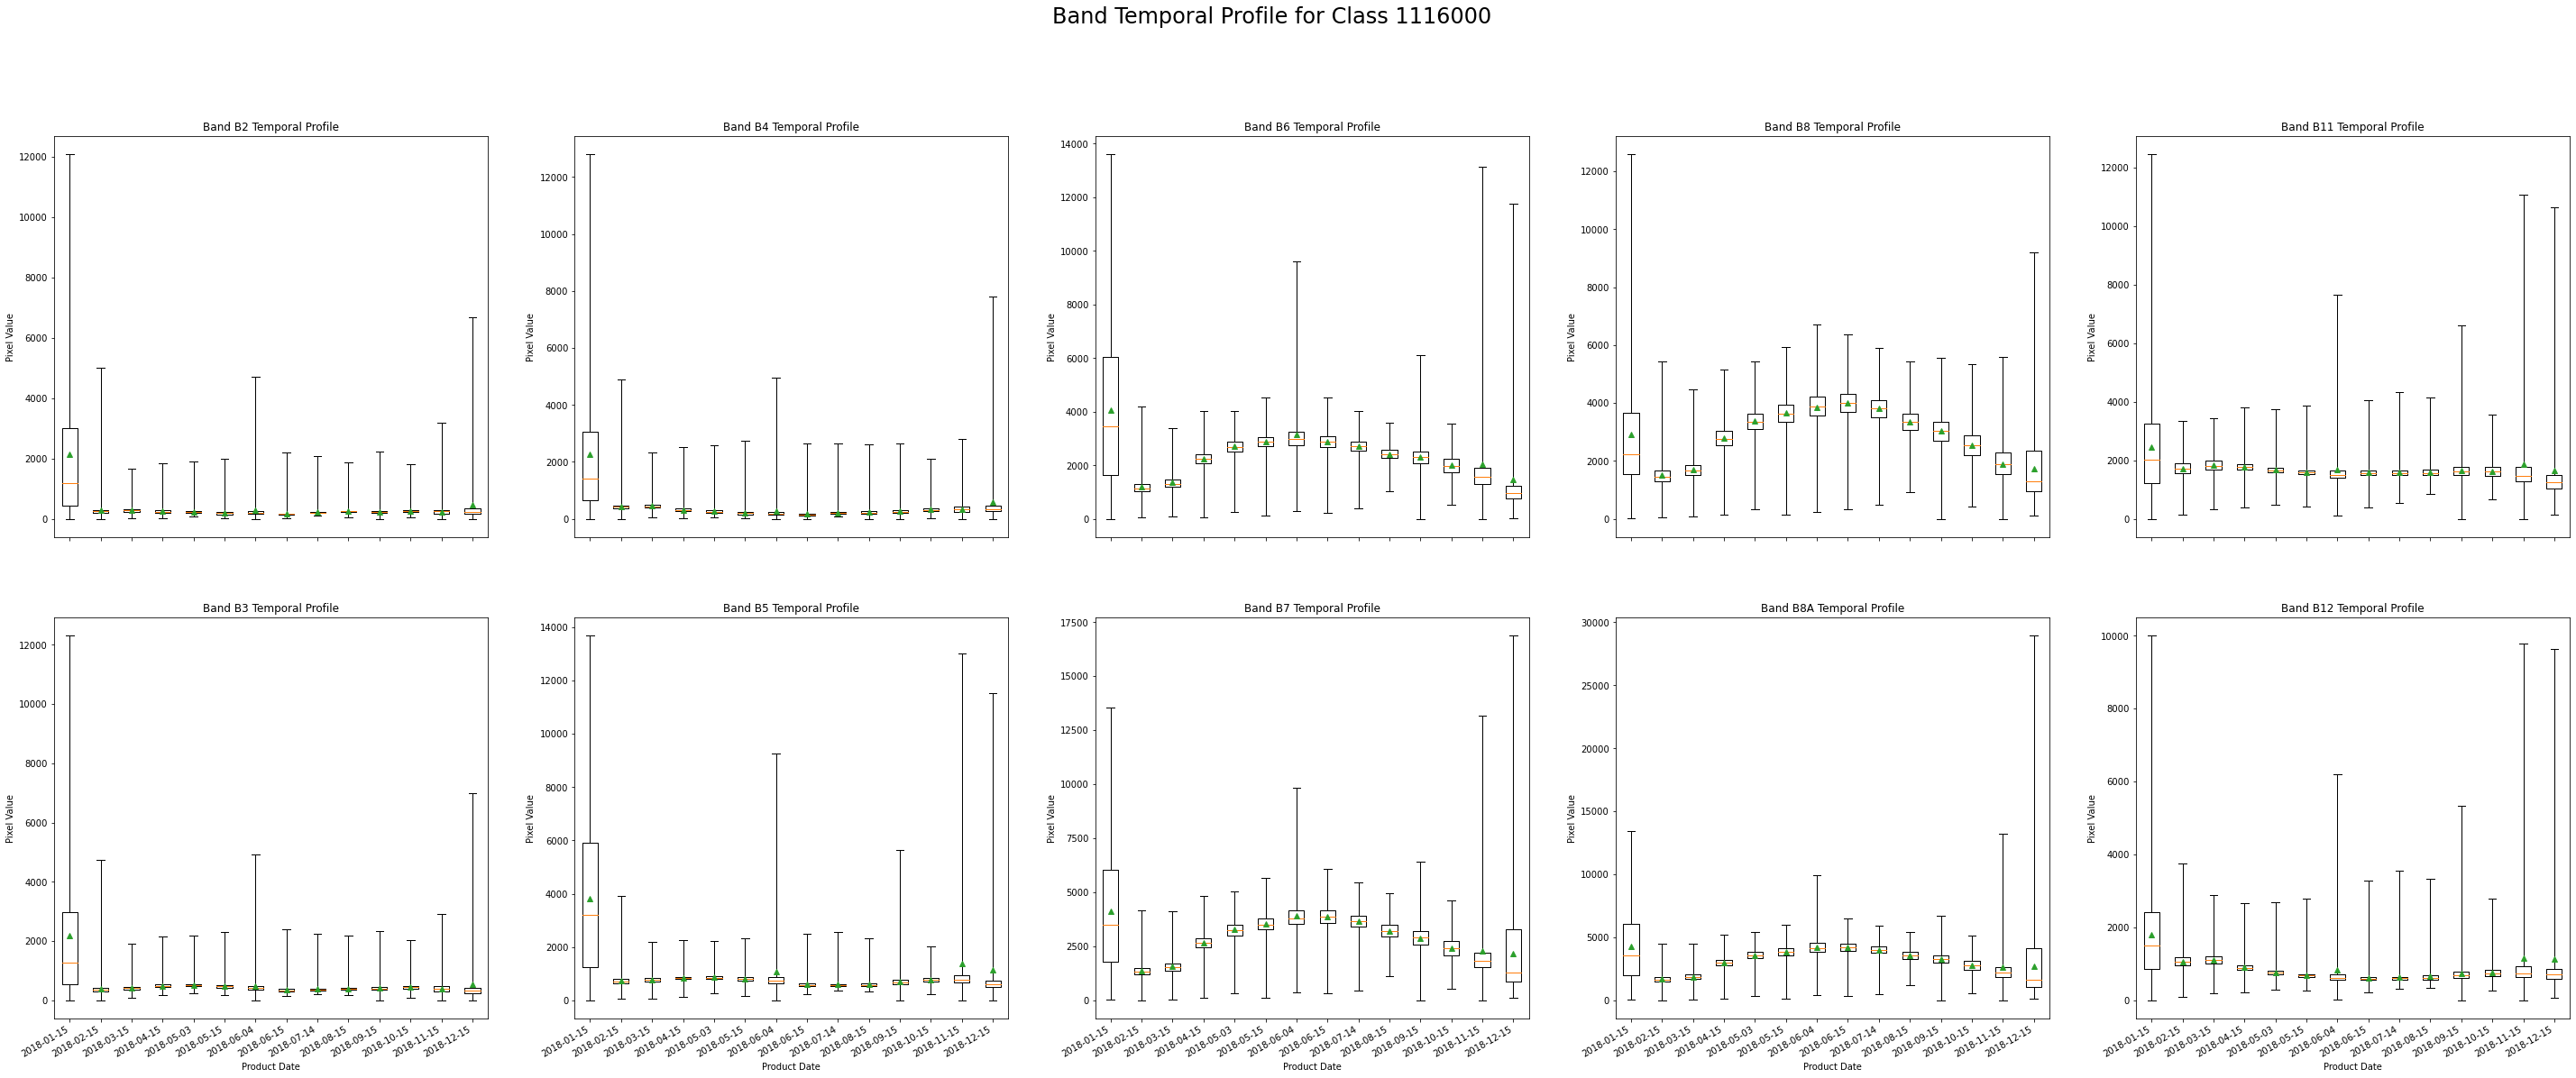

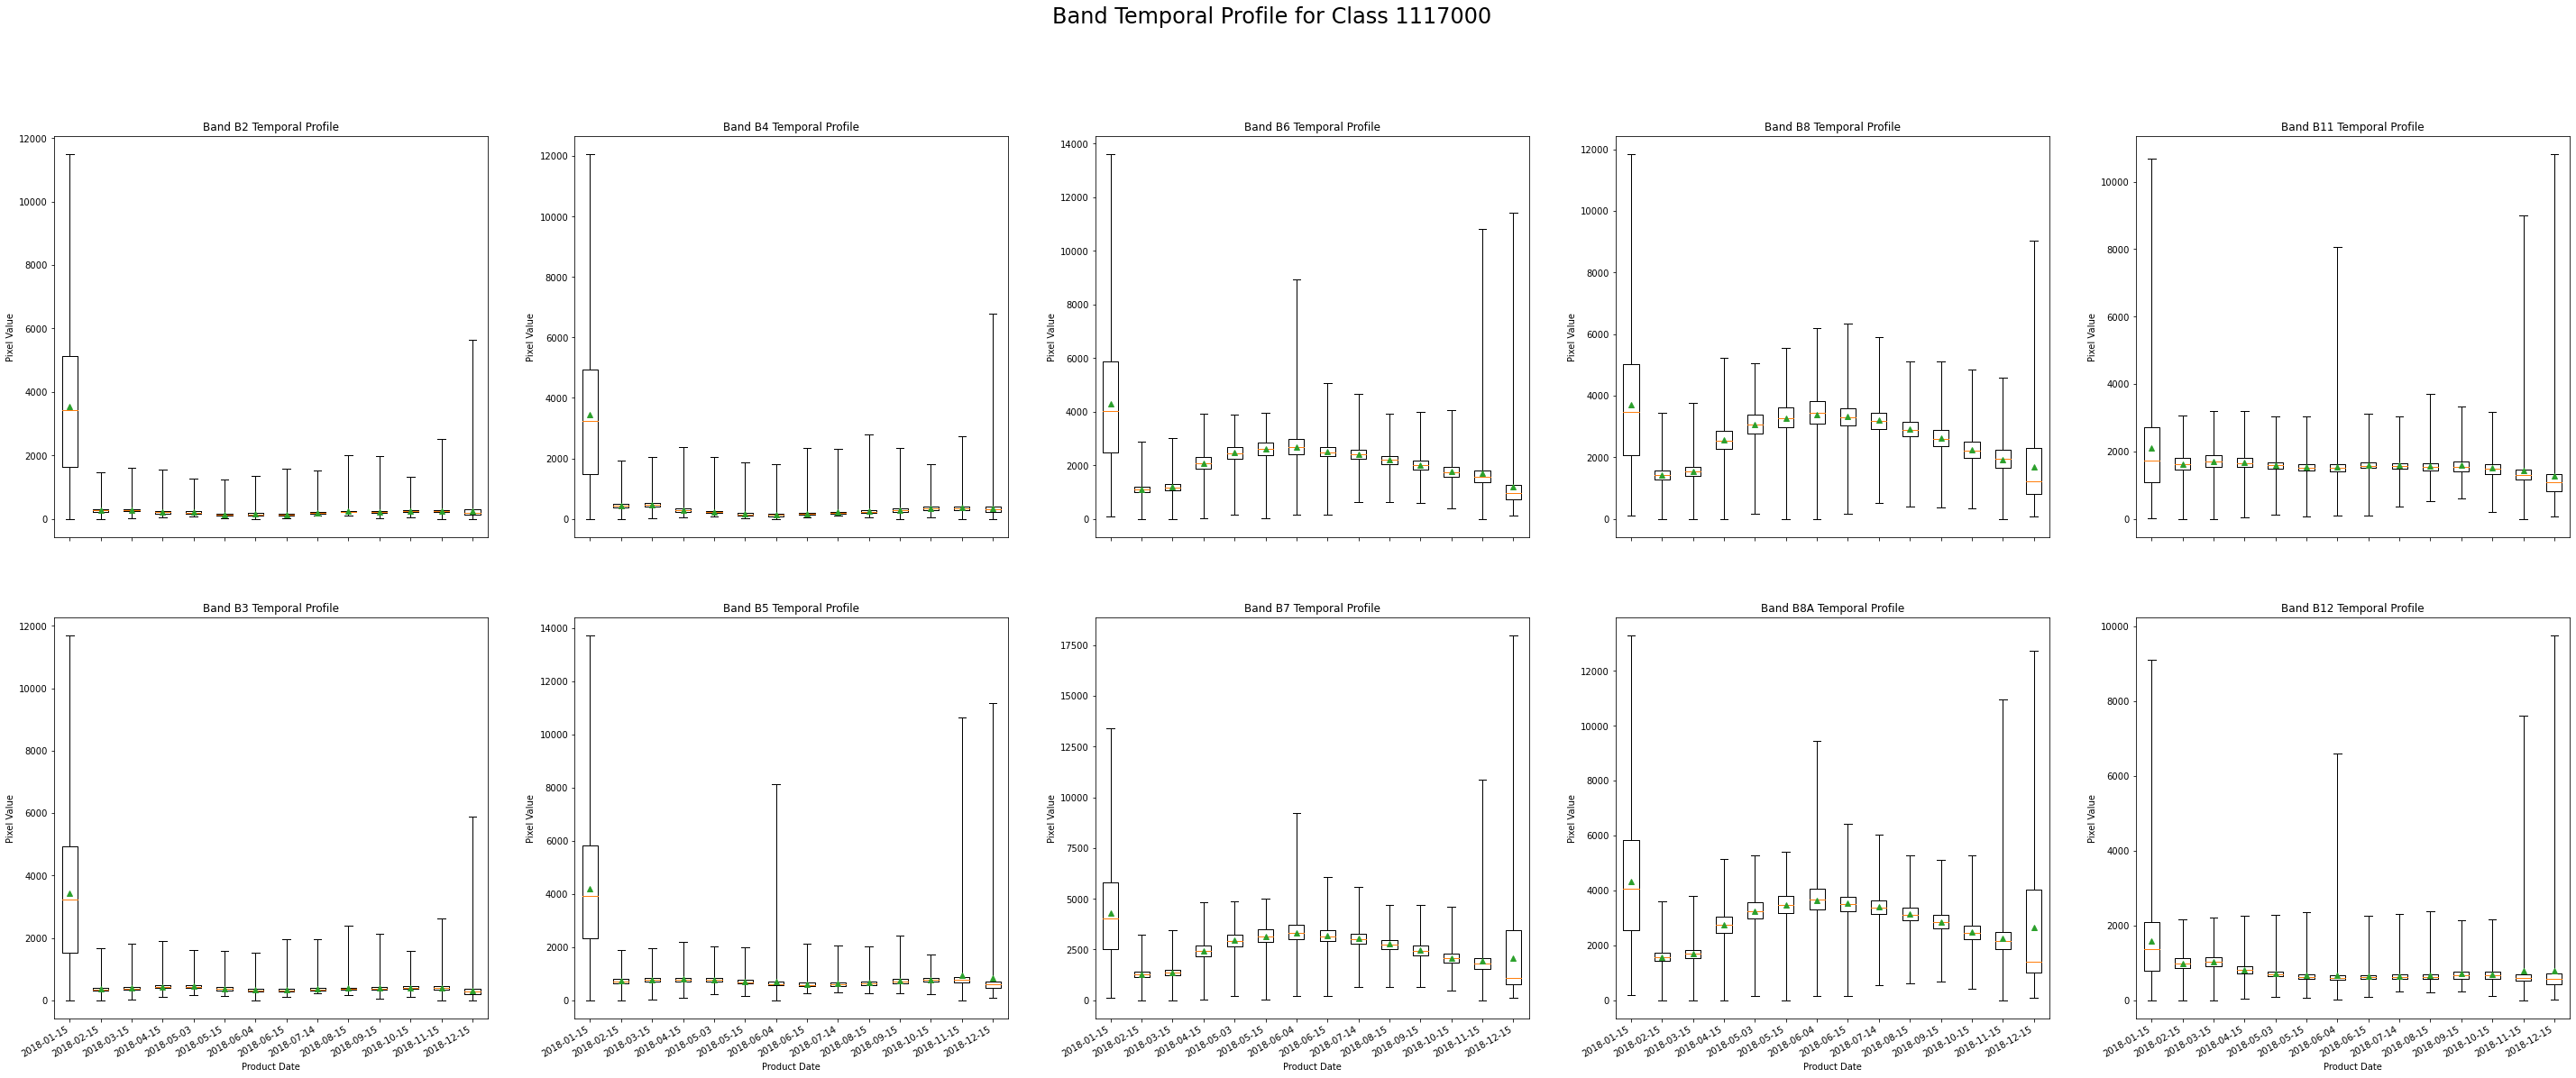

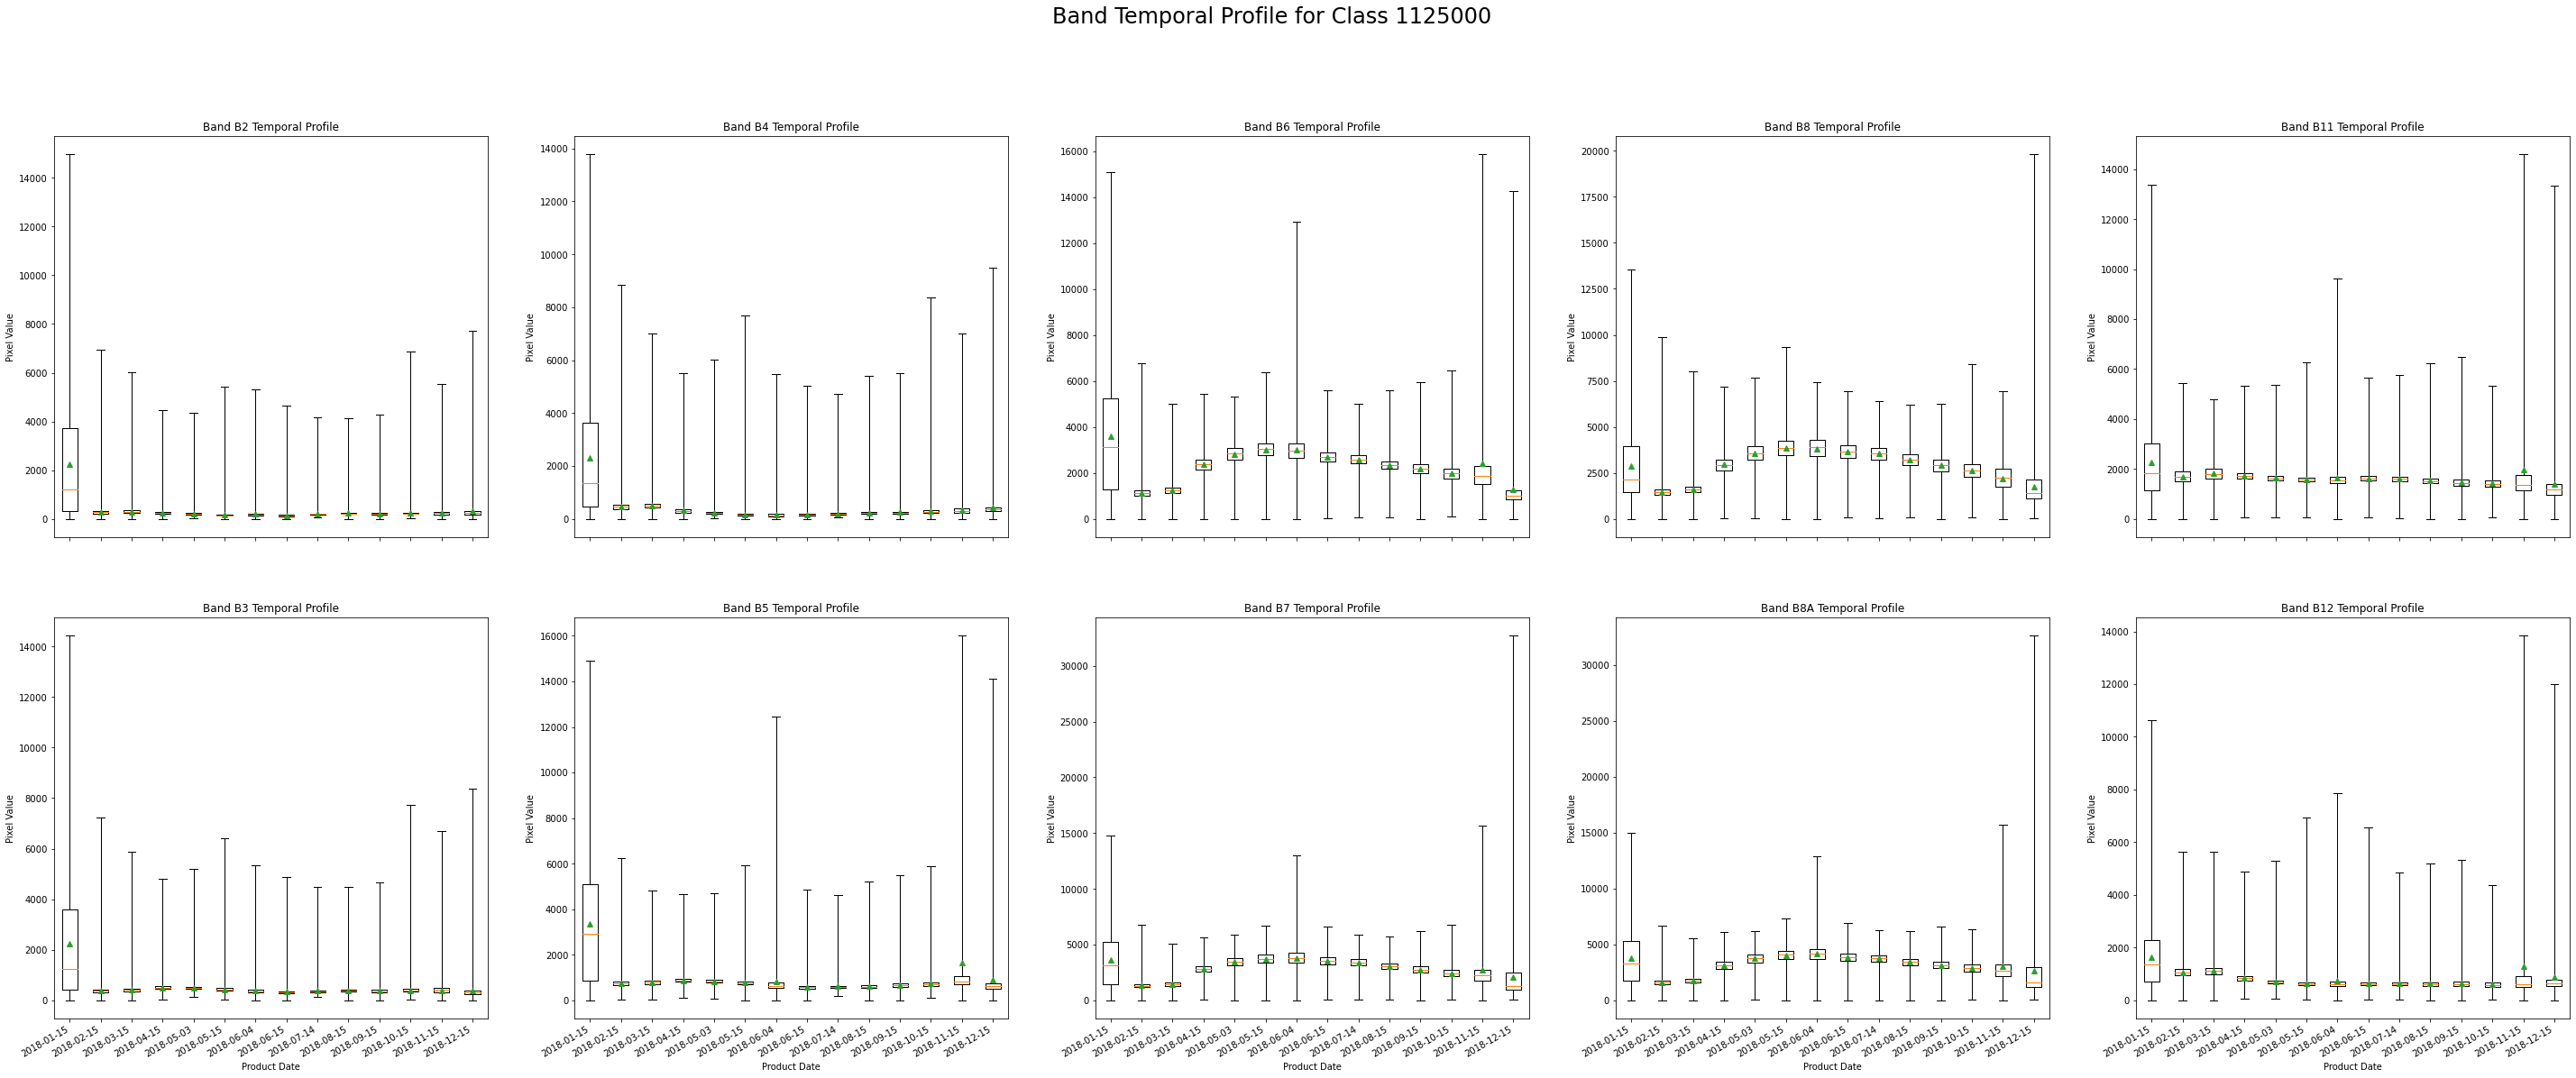

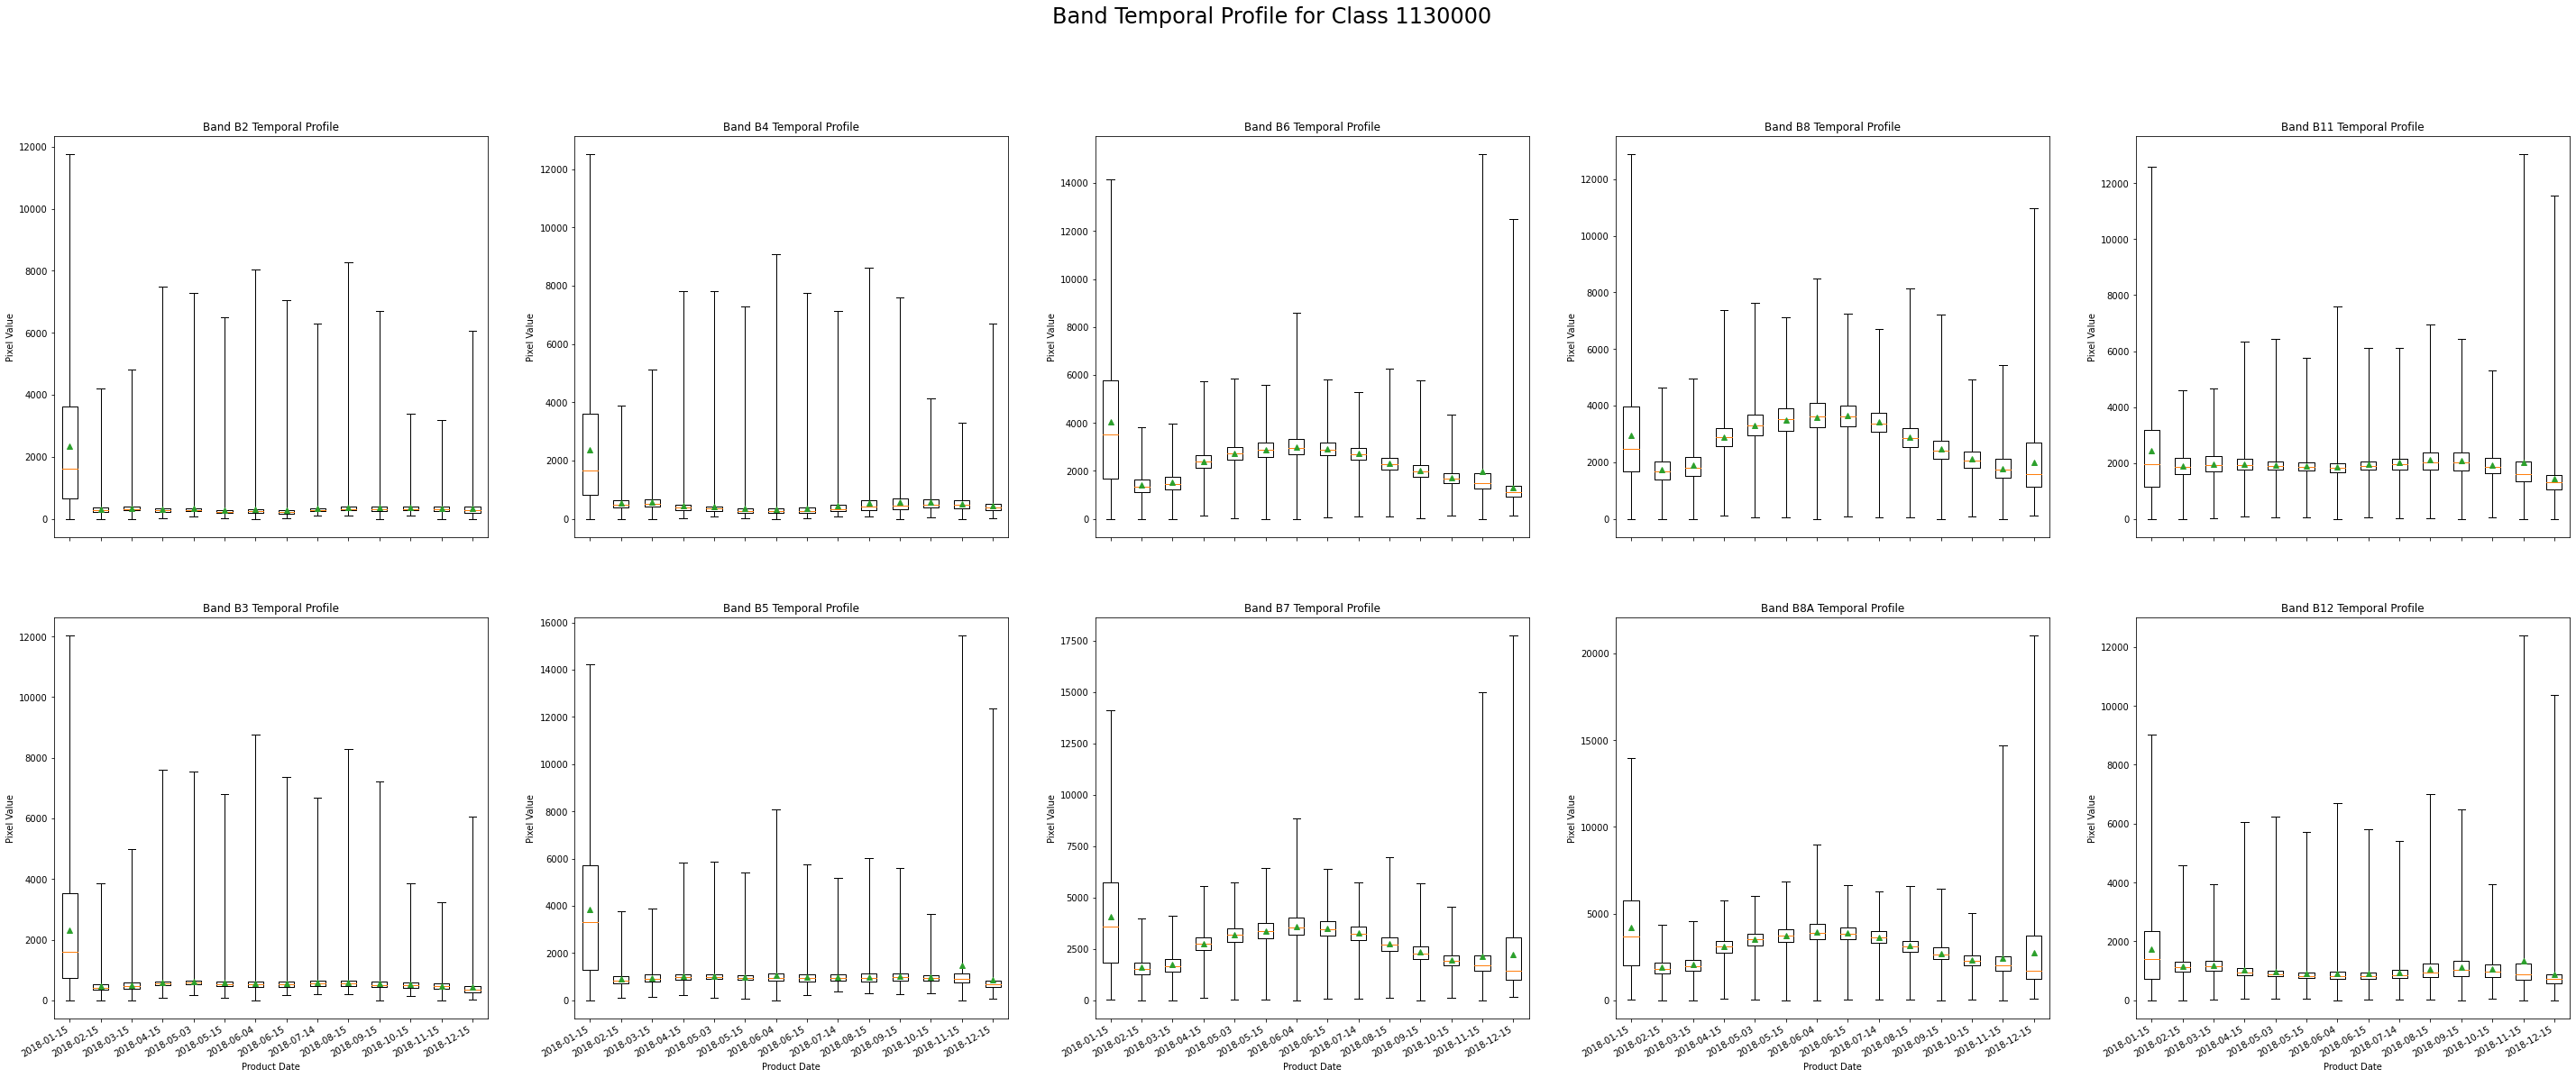

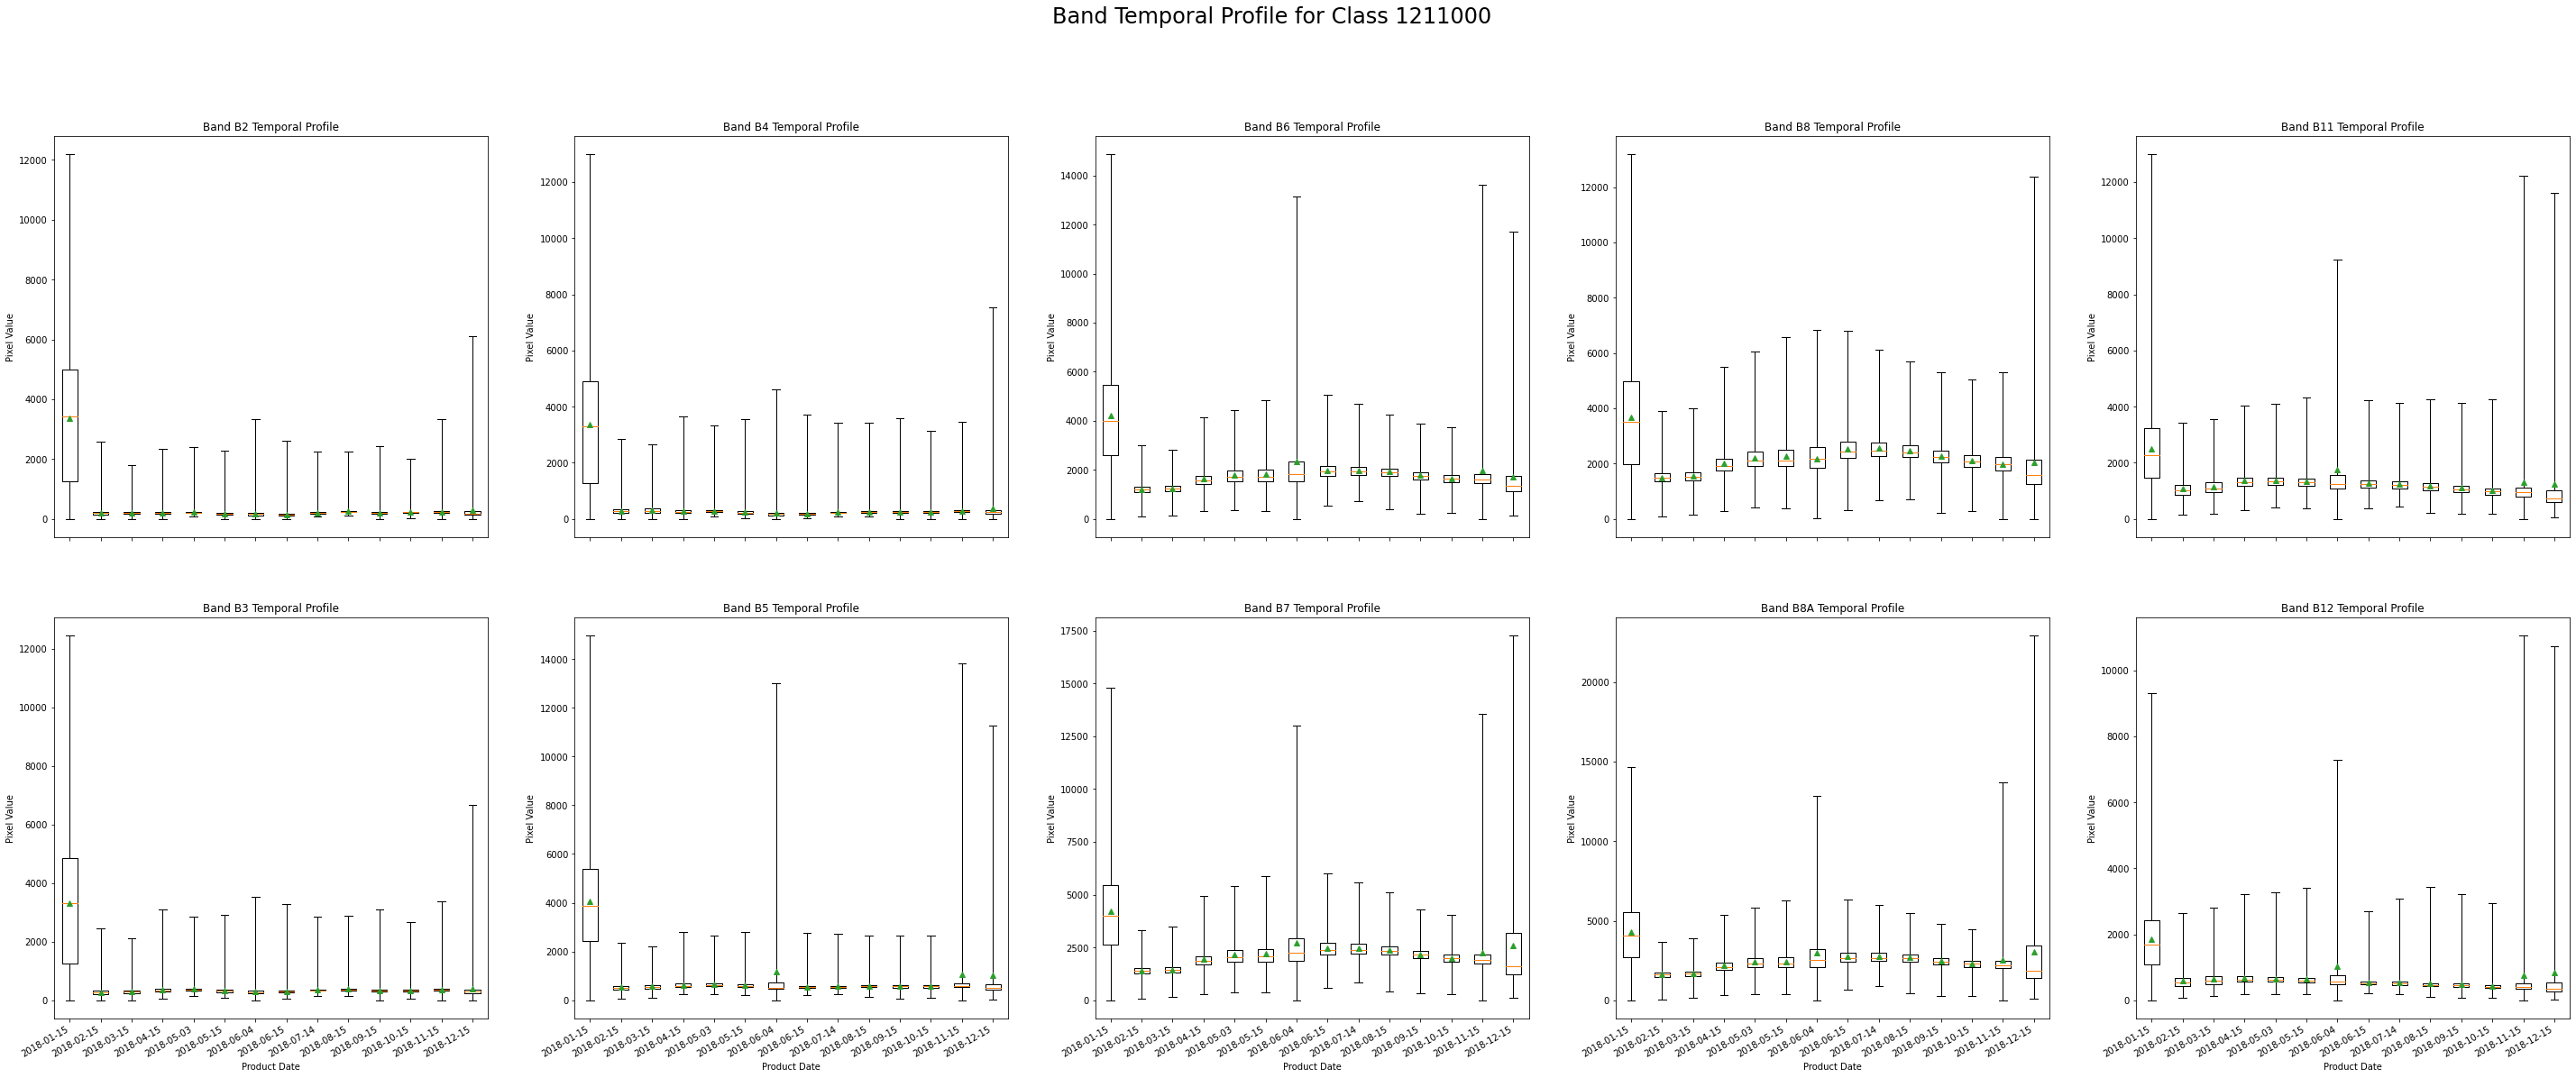

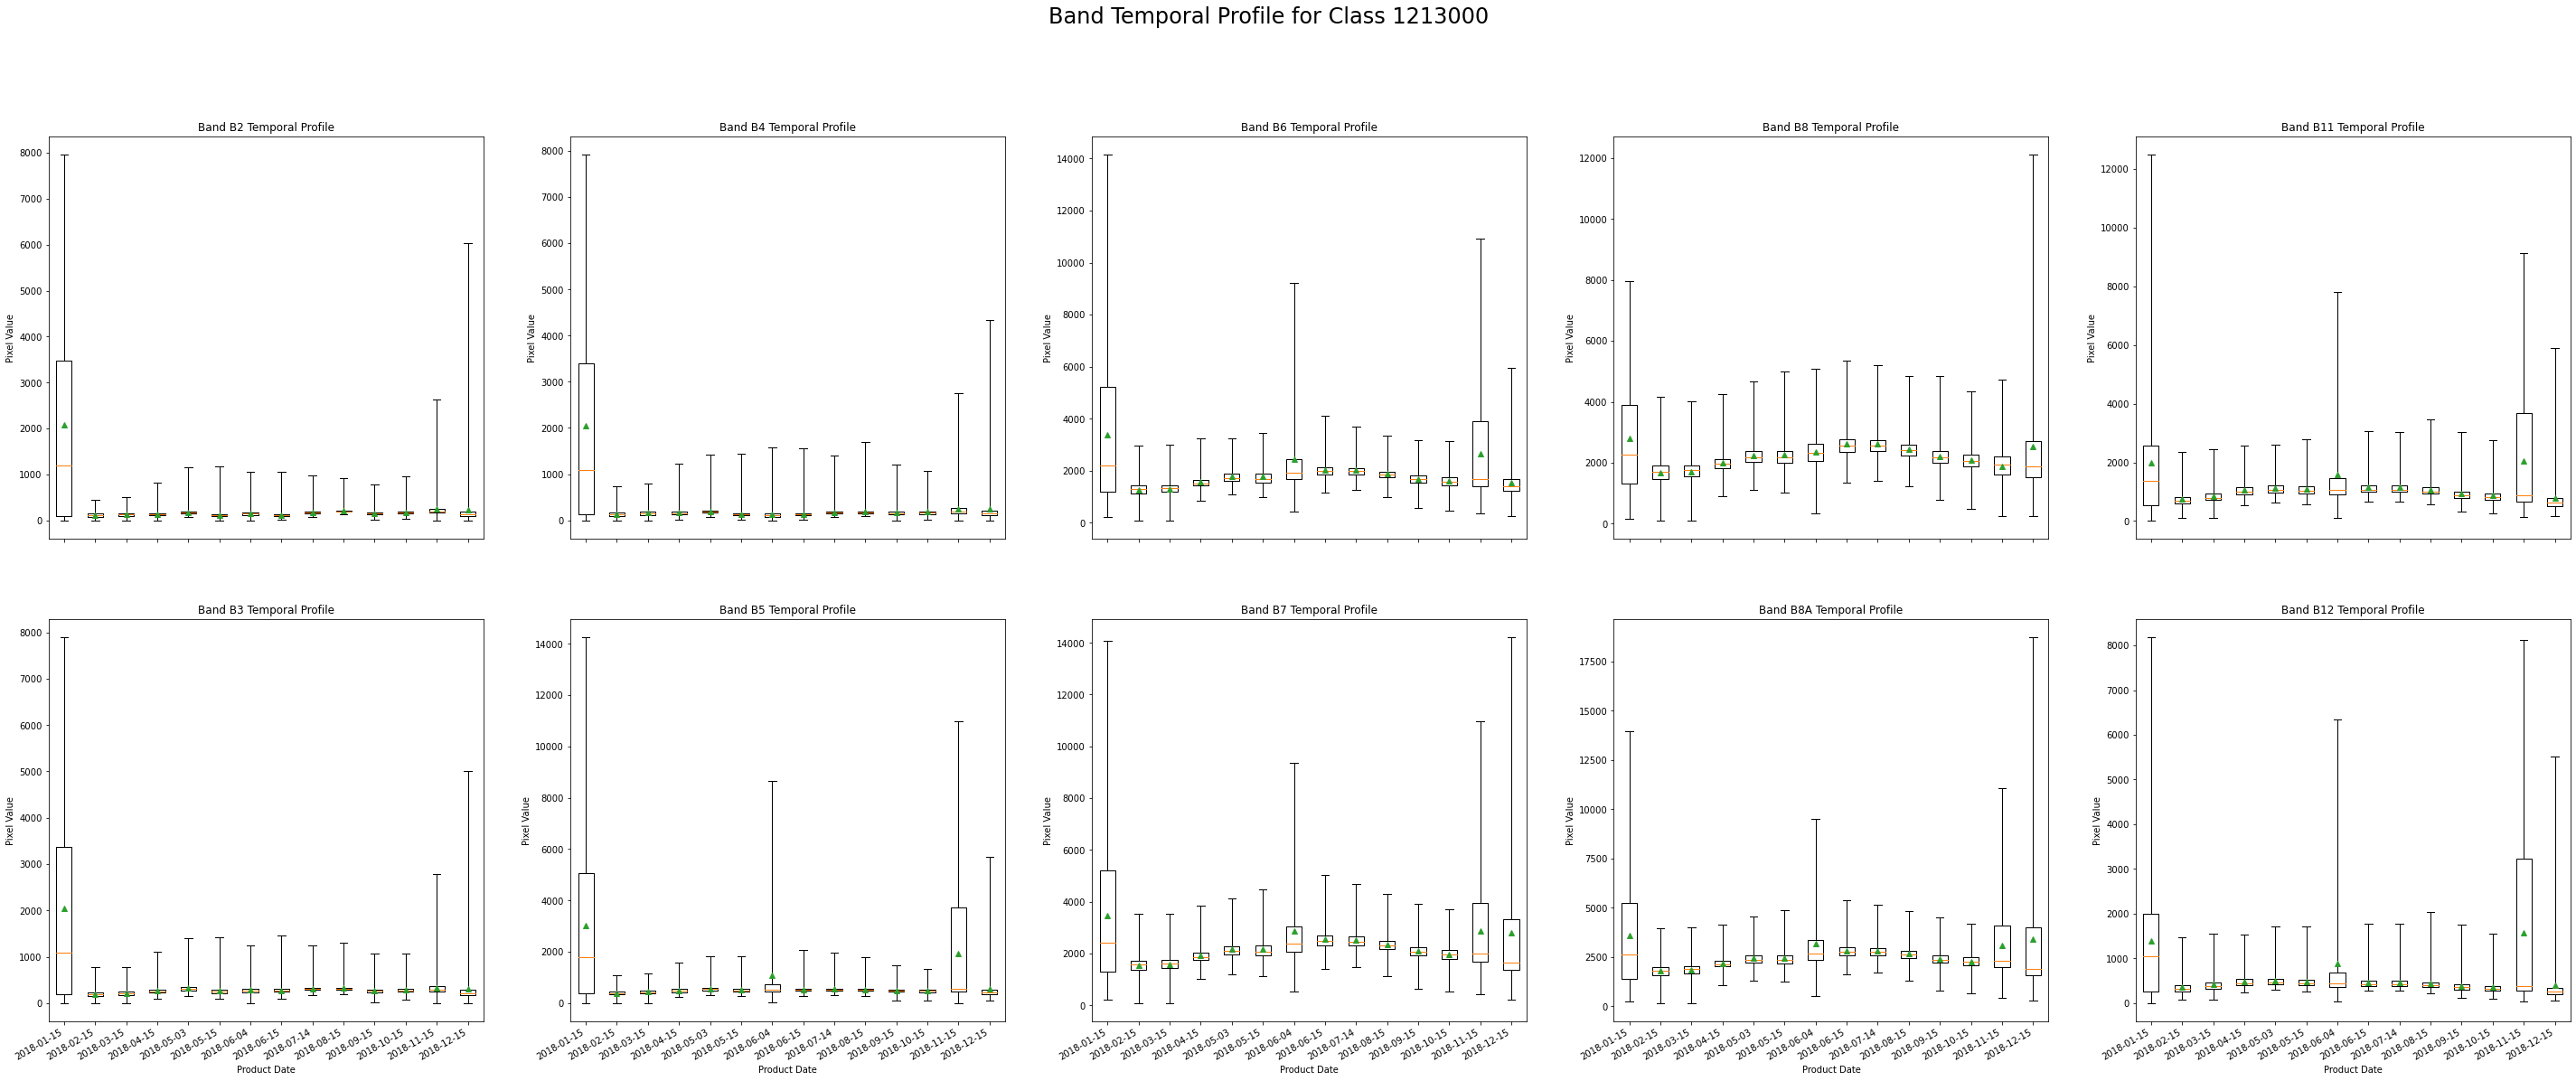

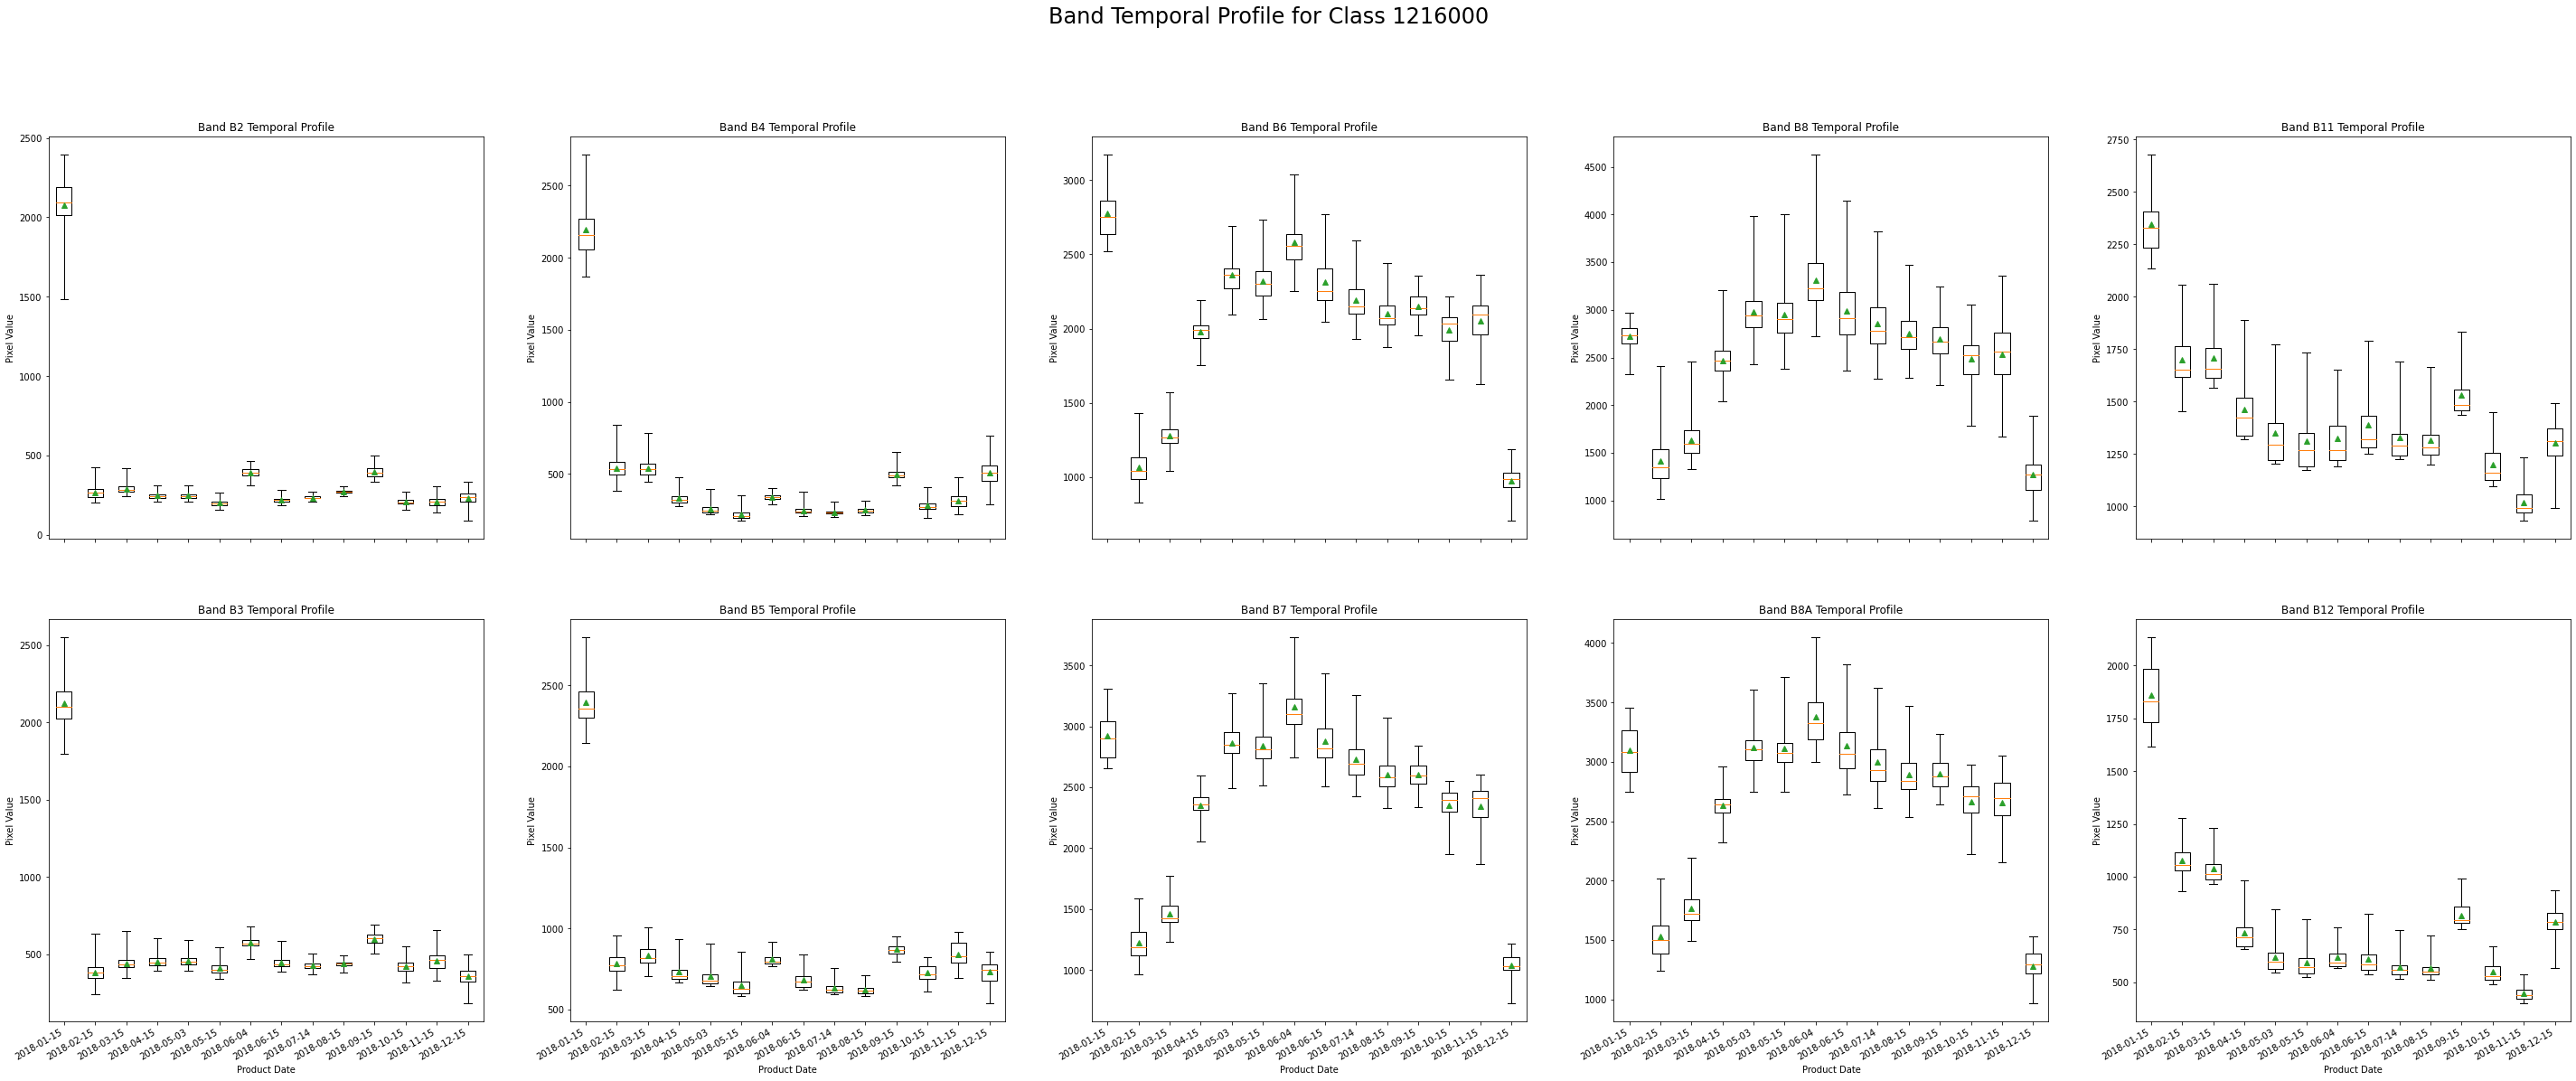

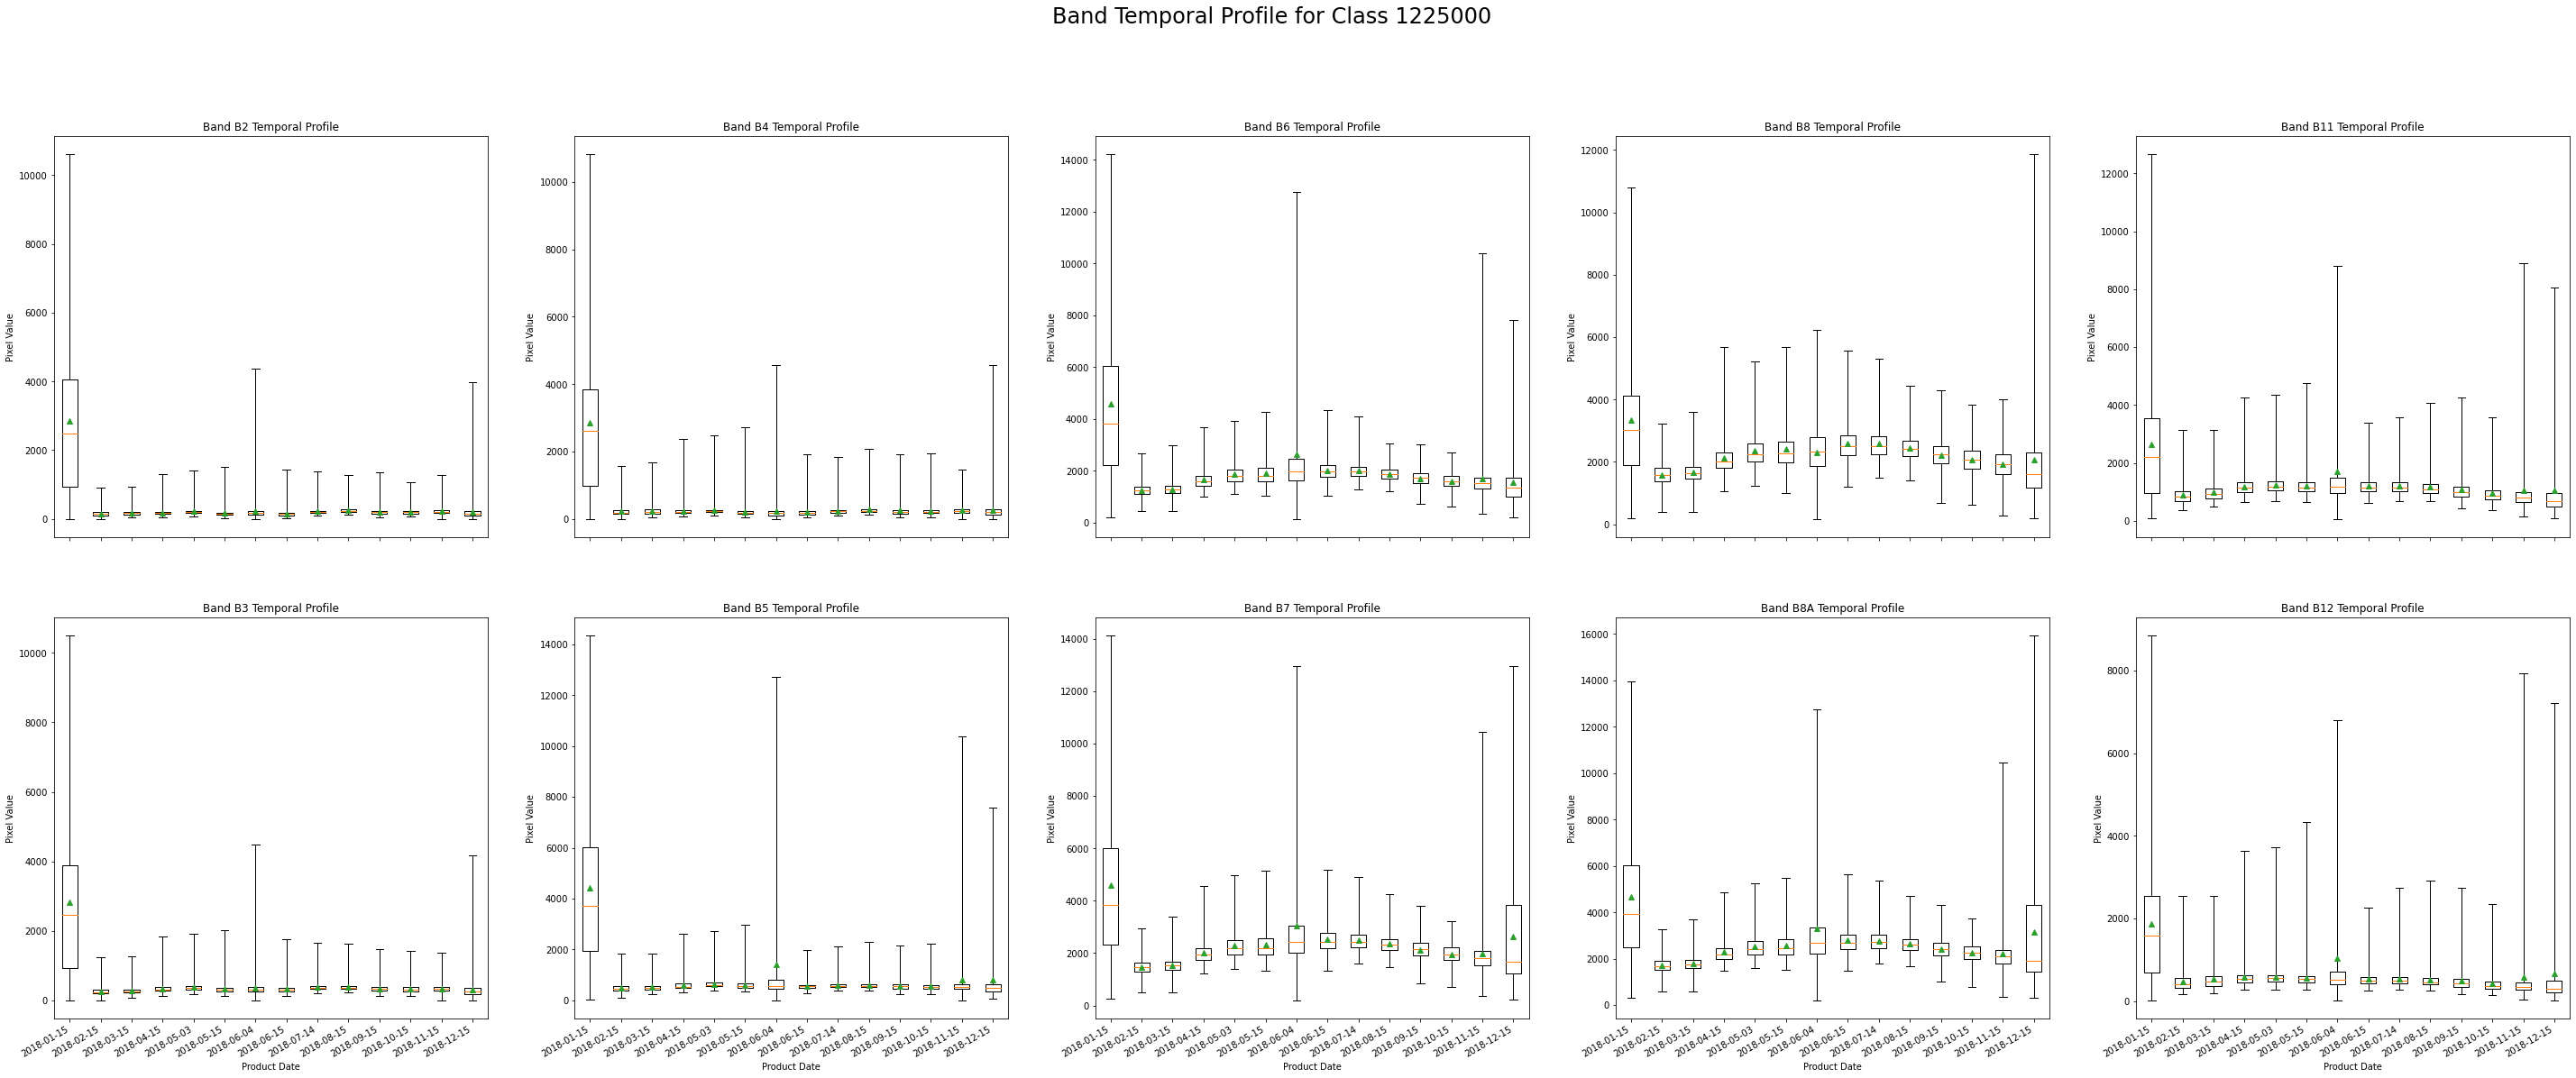

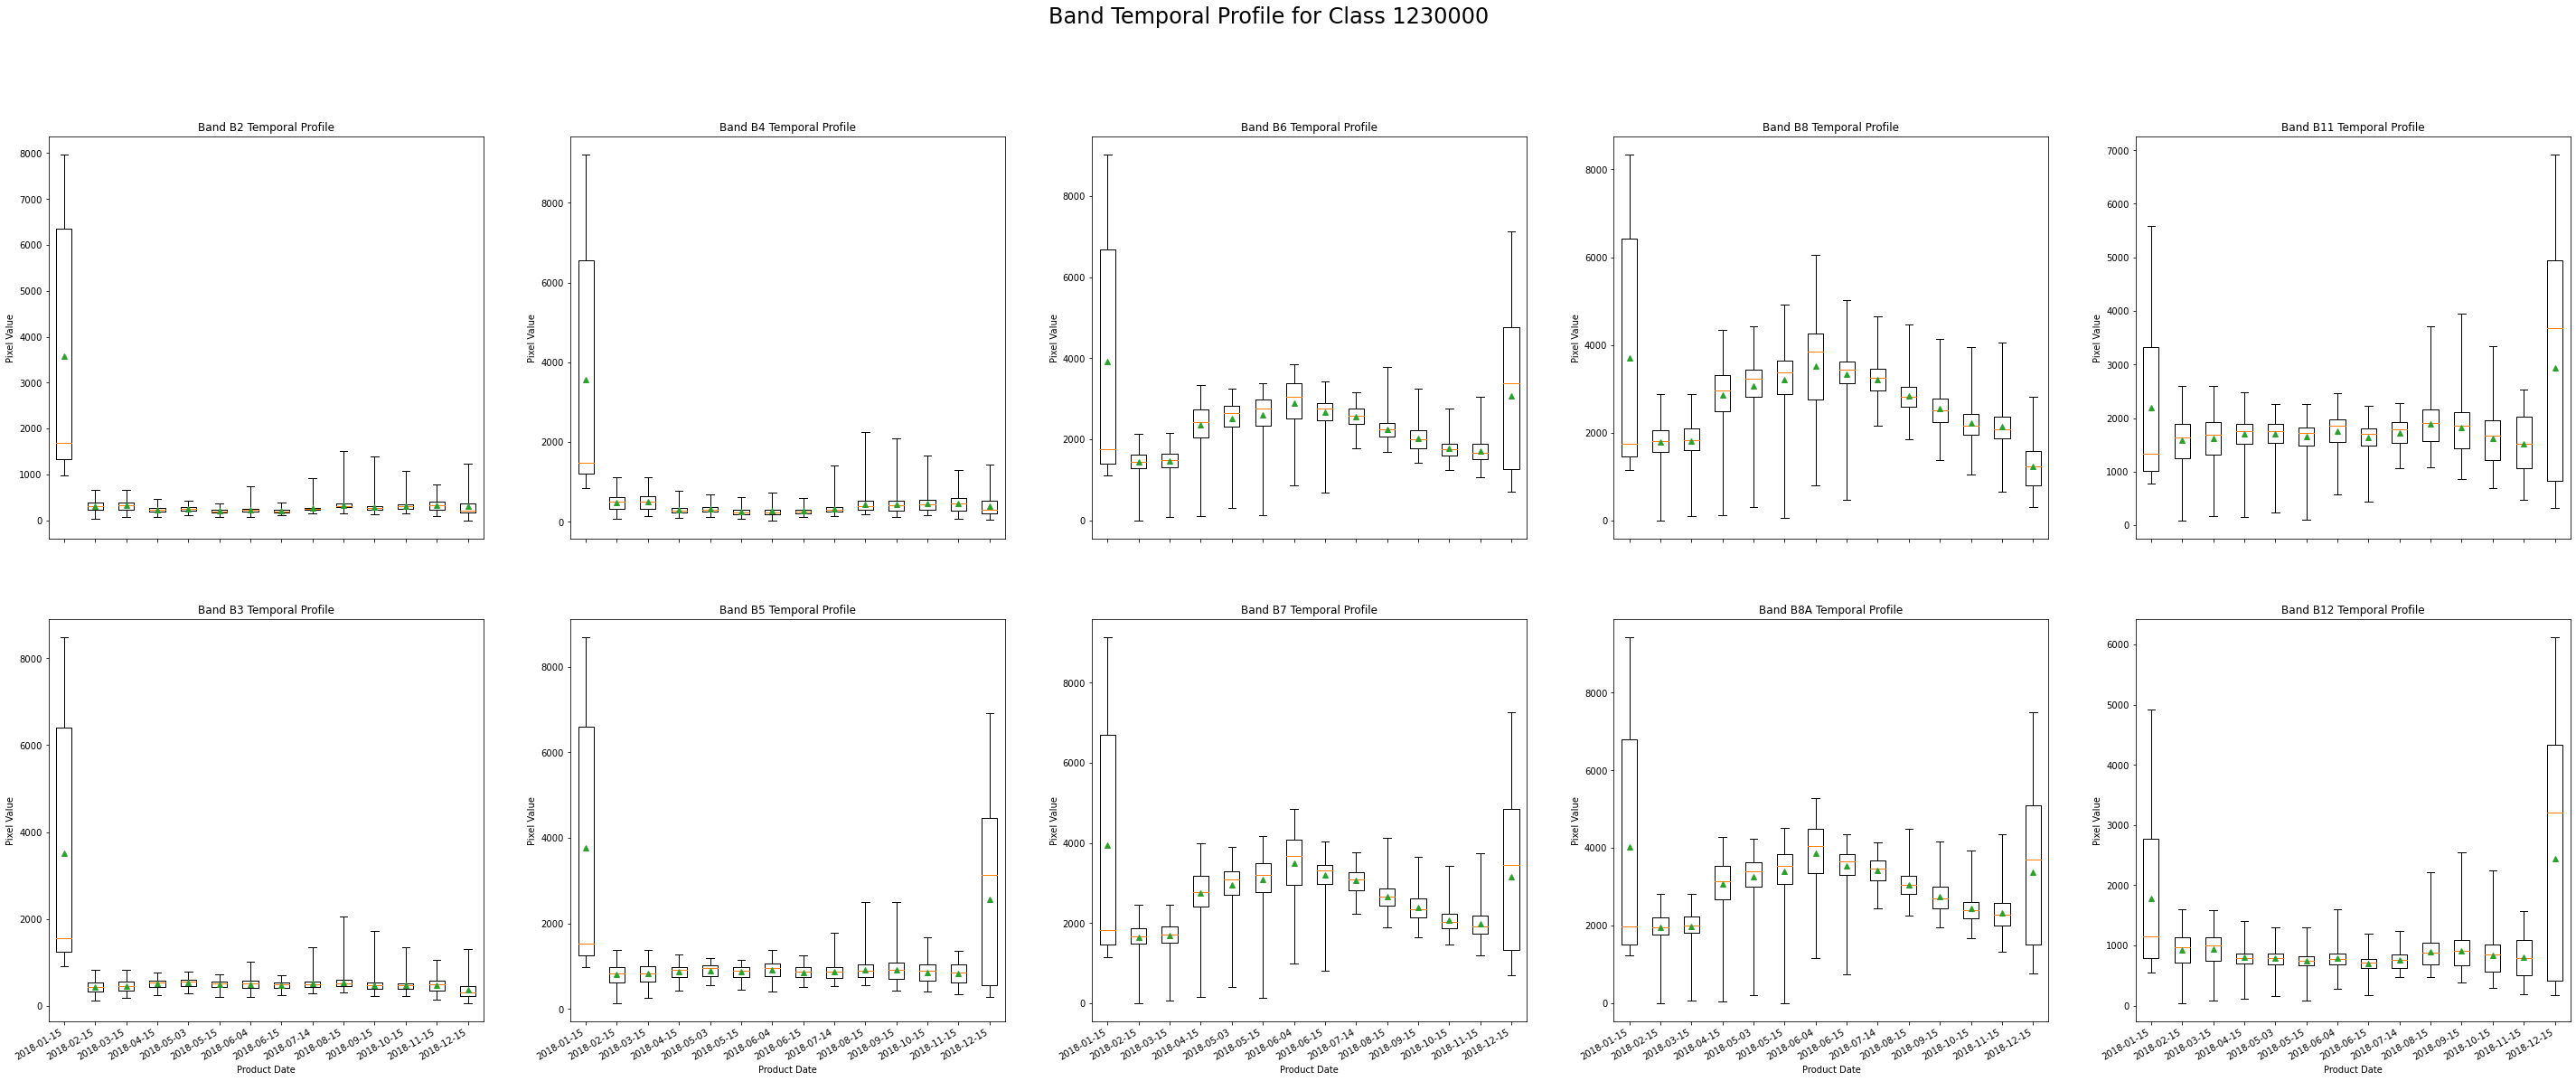

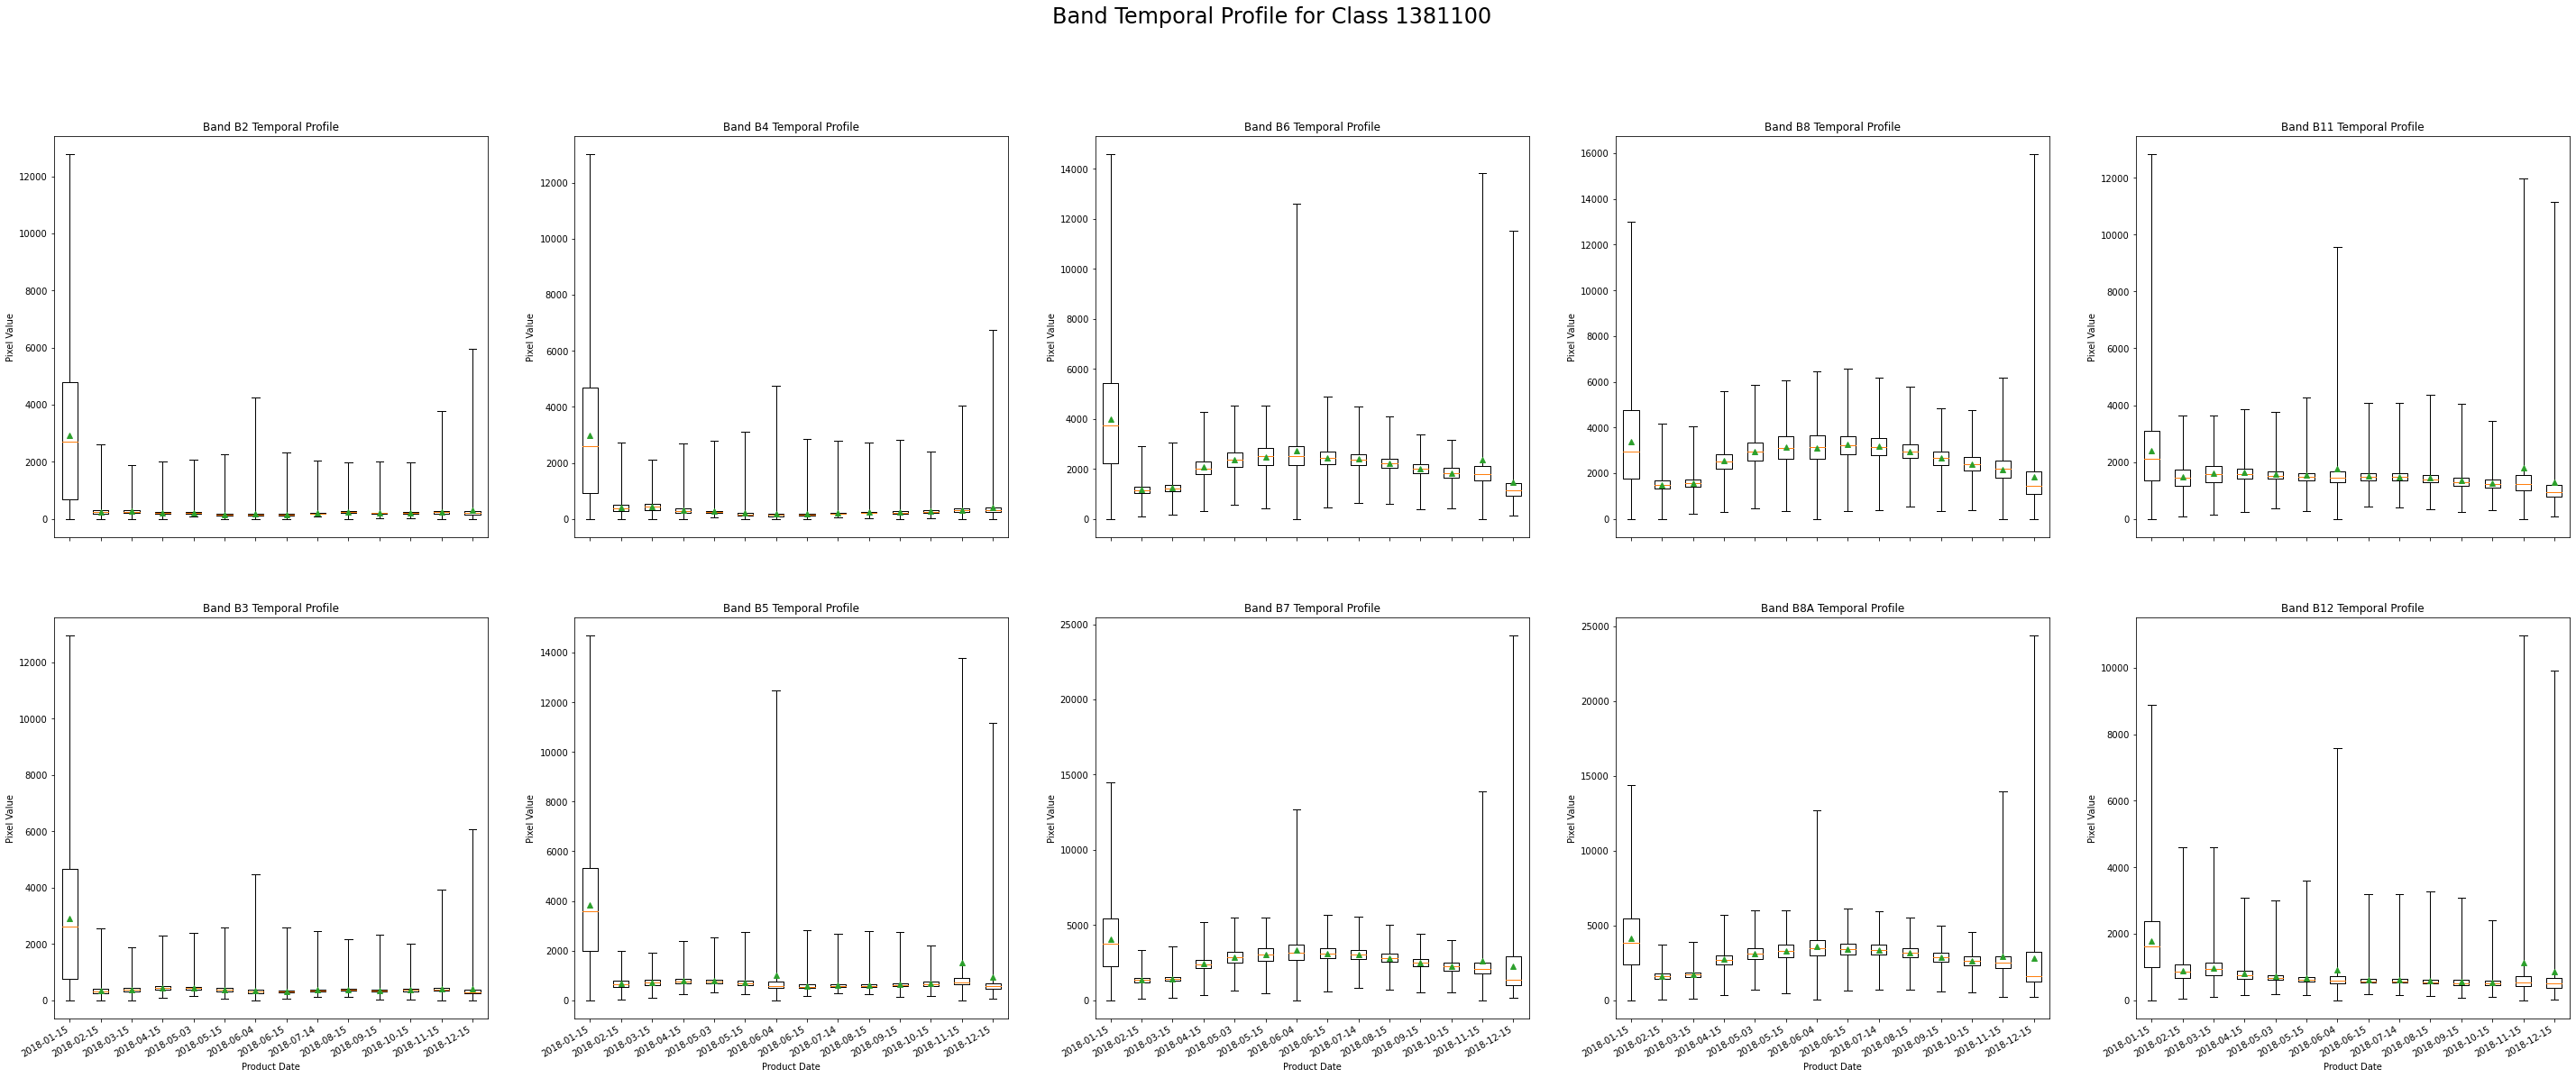

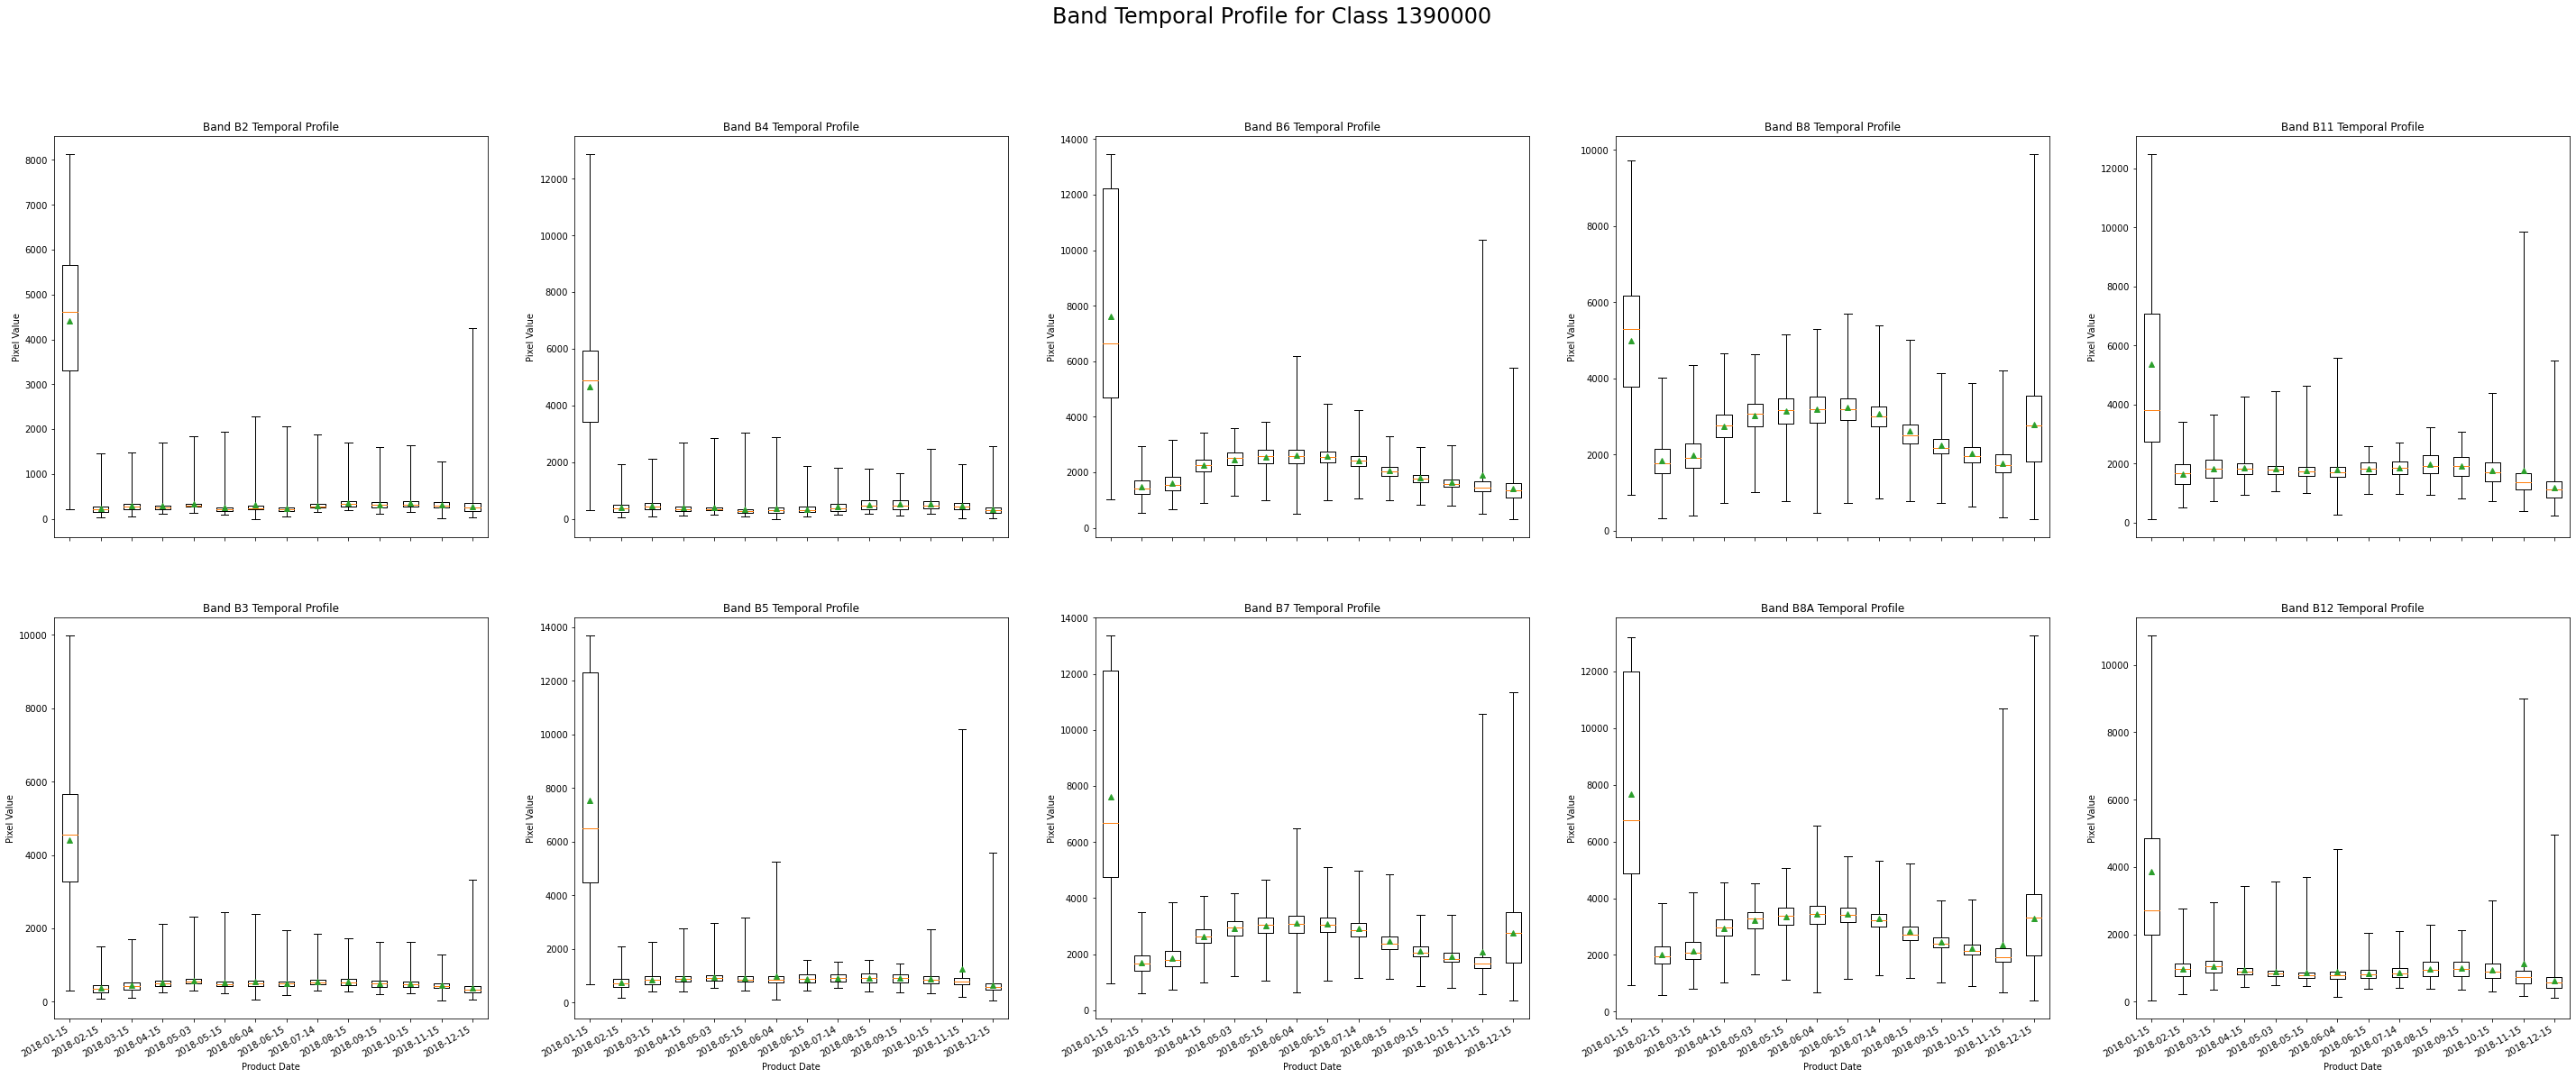

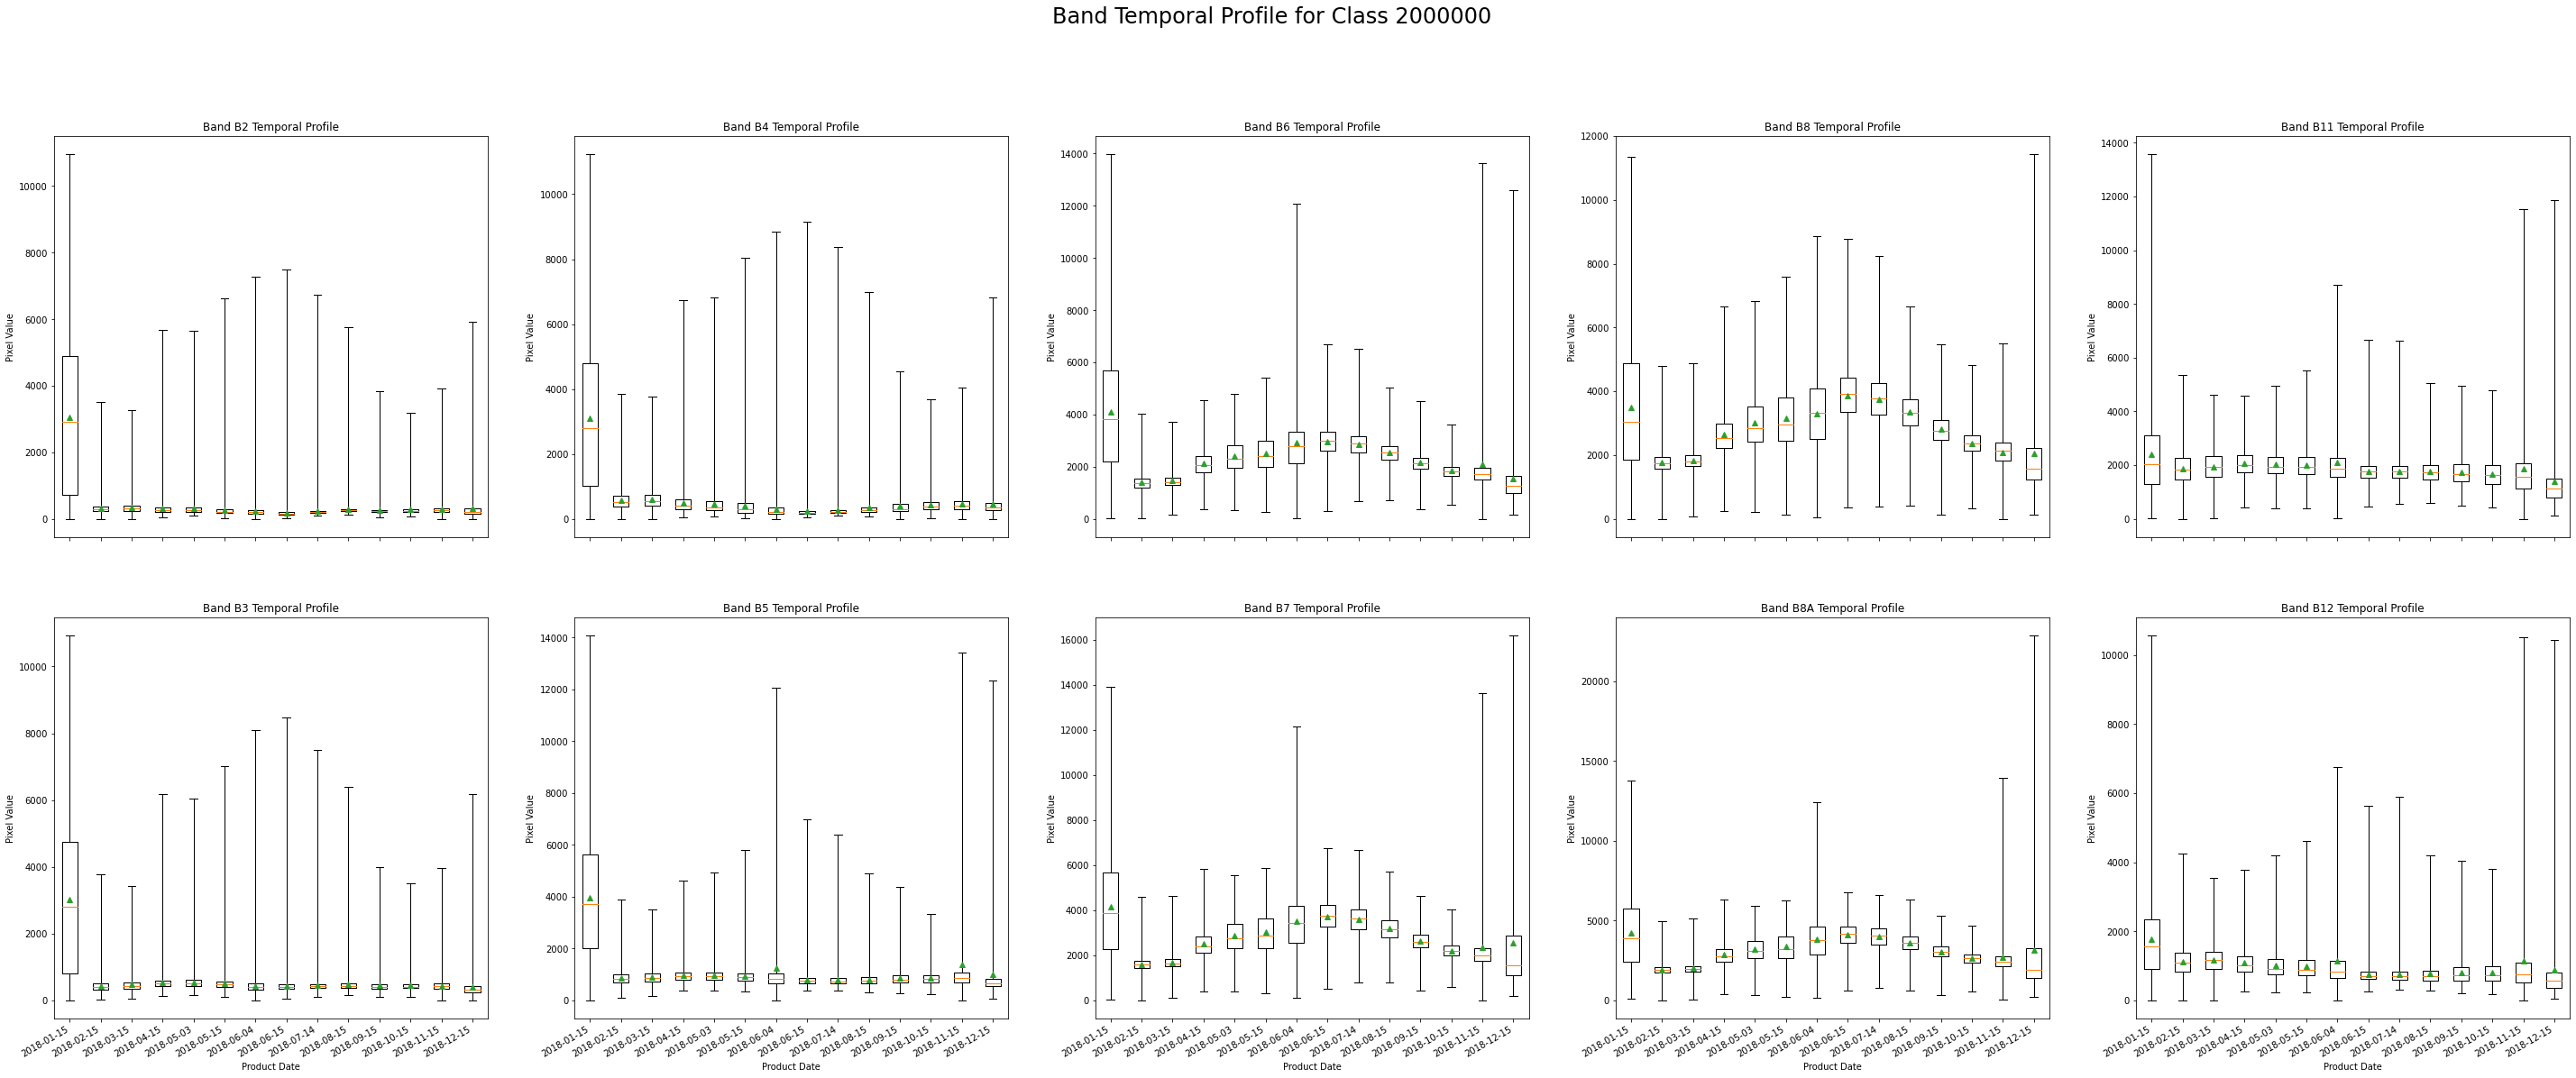

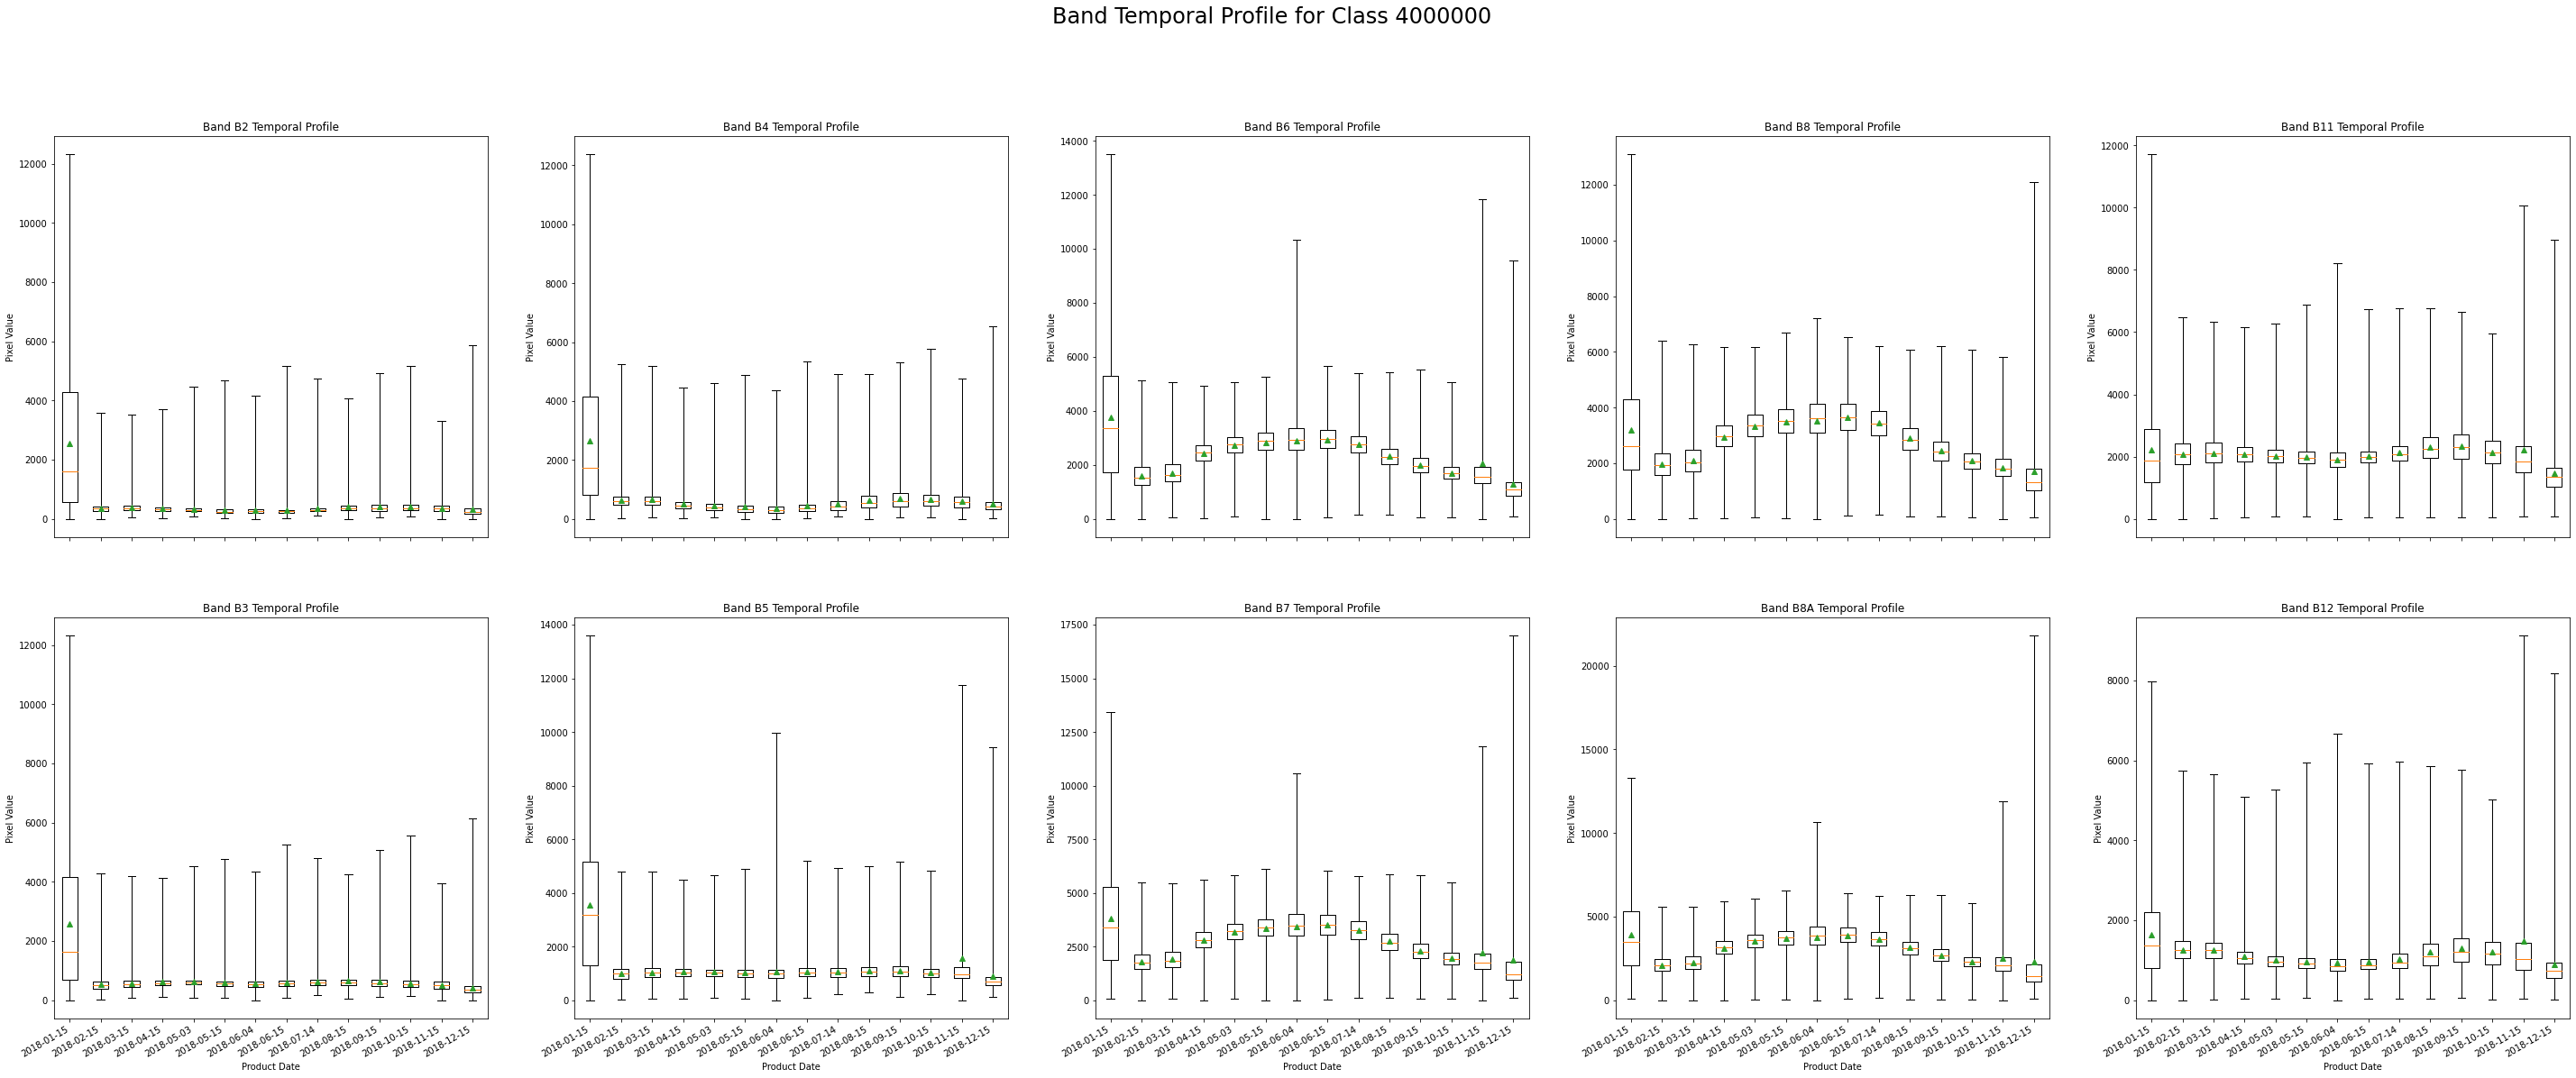

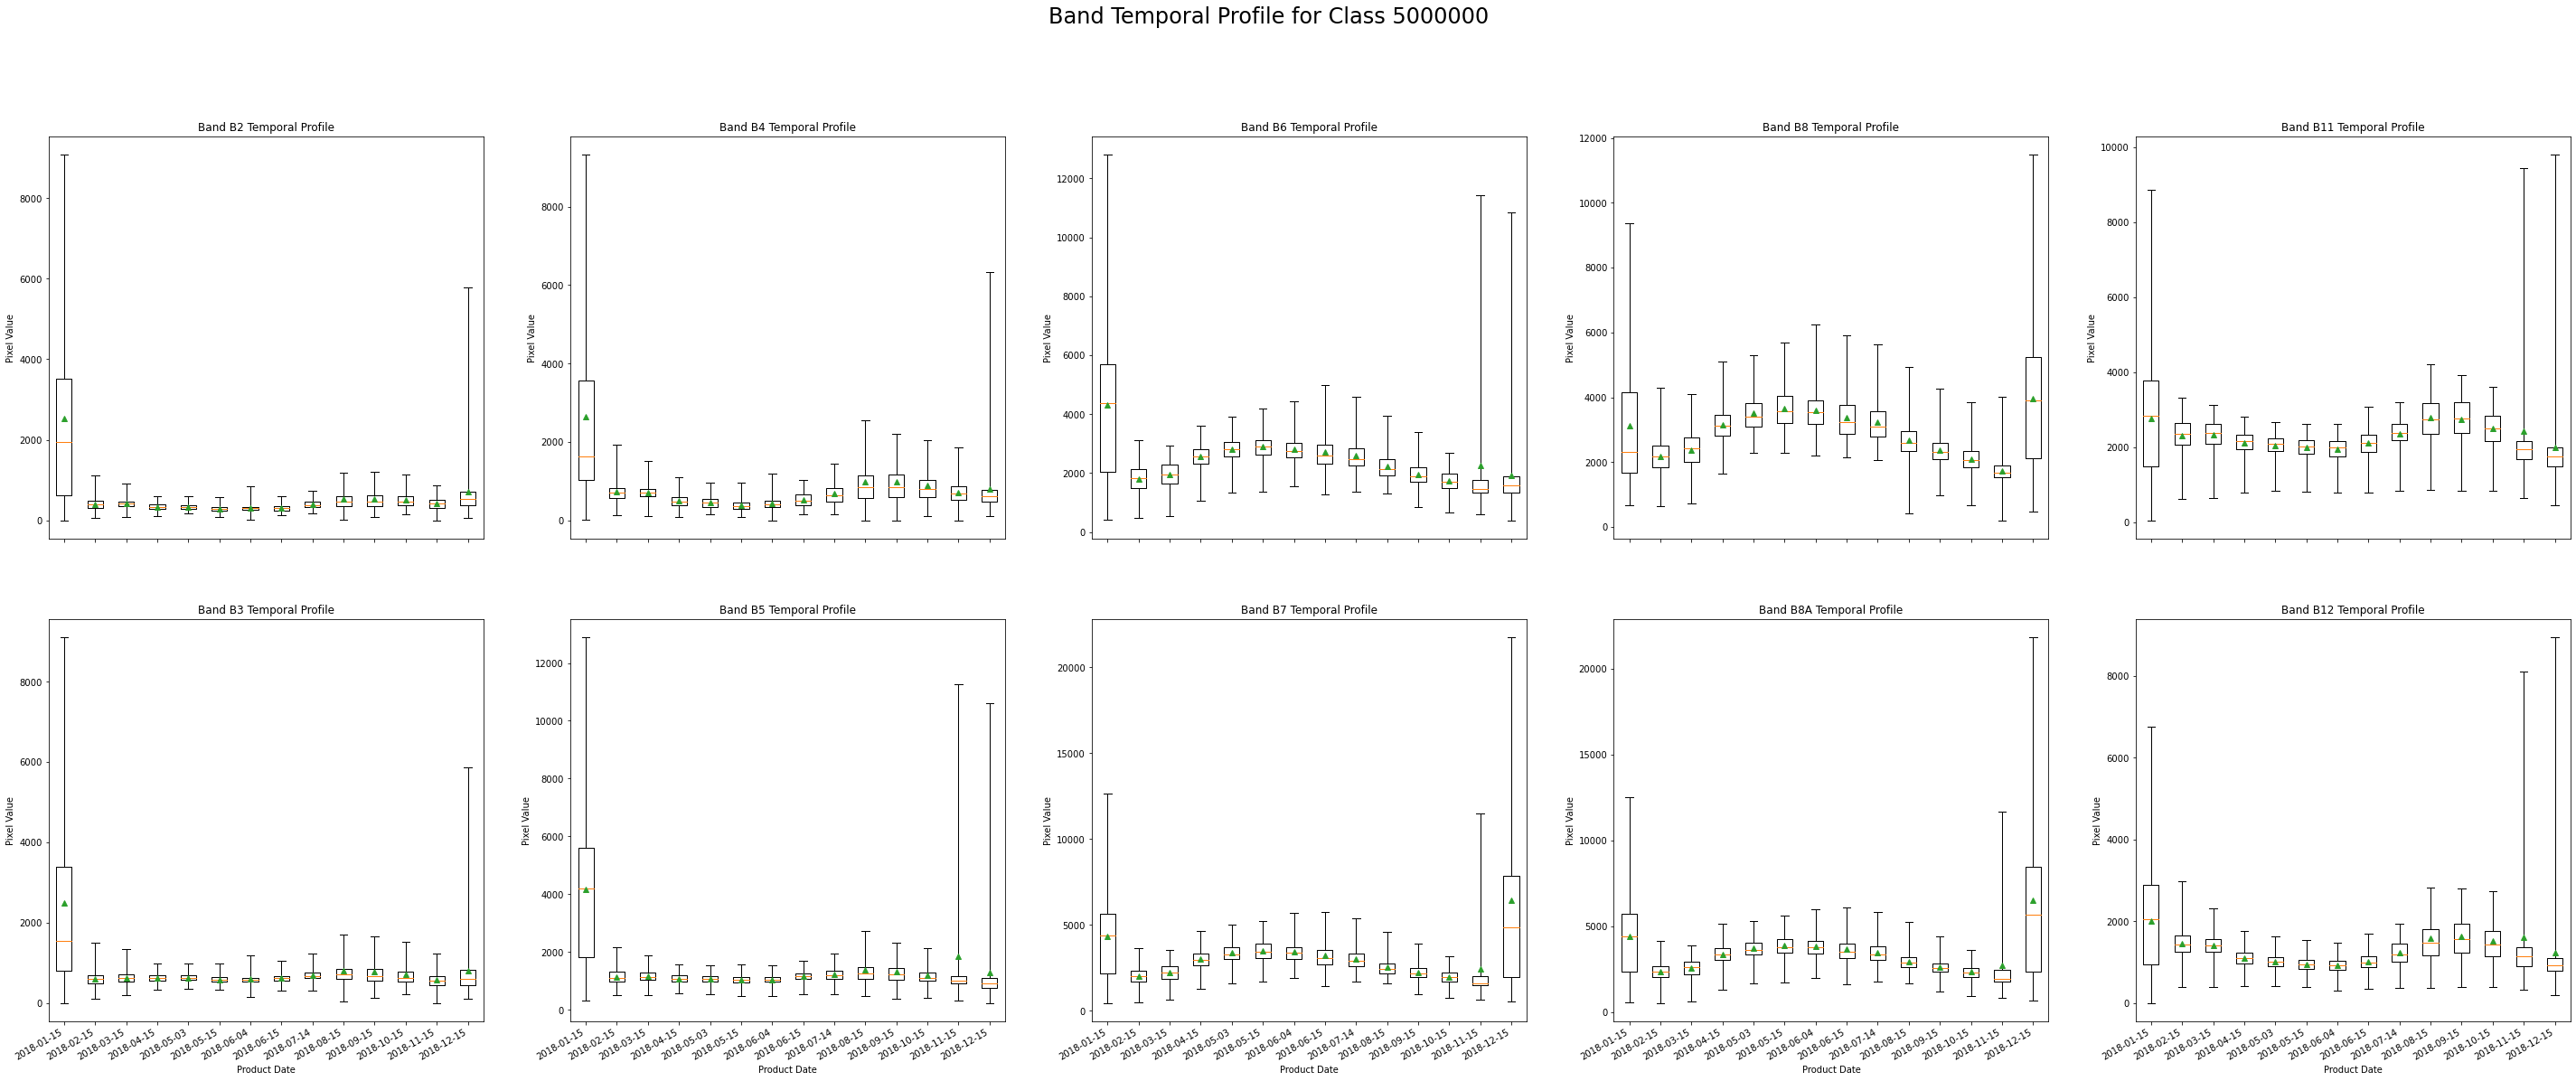

In [13]:
for ess, egroup in statistics.groupby('ess'):
    
    fig, axes = plt.subplots(2, 5, figsize=[50, 20])
    
    essbandgroups = {band: bgroup for band, bgroup in egroup.groupby('band')}
    
    for i, band in enumerate(bands):
        bgroup = essbandgroups[band]
        
        ax = axes[i%2][int(i/2)]
        stats = [box_stat(stat) for name, stat in bgroup.iterrows()]    

        ax.bxp(stats, showmeans=True, showfliers=False)    
        ax.set_title(f"Band {band} Temporal Profile")
        ax.set_ylabel("Pixel Value")
        ax.set_xlabel("Product Date")
        fig.autofmt_xdate()
    
    fig.suptitle(f'Band Temporal Profile for Class {ess}', fontsize=24)
    plt.savefig(join(path['diag'], f'{ess}_temporal.svg'), bbox_inches='tight')
    plt.show()

### Band Temporal Profile

In [ ]:
for band, bgroup in statistics.groupby('band'):
    
    fig, ax = plt.subplots(figsize=[50, 20])    
    
    stats = [box_stat(stat) for name, stat in bgroup.iterrows()]    
    ax.bxp(stats, showmeans=True, showfliers=False)
        
    ax.set_title(f"Band {band} Temporal Profile")
    ax.set_ylabel("Pixel Value")
    ax.set_xlabel("Product Date")
    fig.autofmt_xdate()
    fig.suptitle(f'Class Temporal Profile for Band {band}', fontsize=24)
    
    plt.savefig(join(path['diag'], f'{band}_temporal.svg'), bbox_inches='tight')
    plt.show()
    break